<a href="https://colab.research.google.com/github/Ehsan-Roohi/DSMC_Python/blob/main/Cavity_DSMC_UQ.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Parsing file: ./CavityKn01.dat...
Successfully parsed 2500 points and 11 variables.

Data preprocessing complete.

Training Model 1/5
Finished training model 1. Final validation loss: 0.000824

Training Model 2/5
Finished training model 2. Final validation loss: 0.000870

Training Model 3/5
Finished training model 3. Final validation loss: 0.000772

Training Model 4/5
Finished training model 4. Final validation loss: 0.000852

Training Model 5/5
Finished training model 5. Final validation loss: 0.000817

Predicting with ensemble and calculating uncertainty...

Generating UQ visualization...


RuntimeError: Colorbar layout of new layout engine not compatible with old engine, and a colorbar has been created.  Engine not changed.

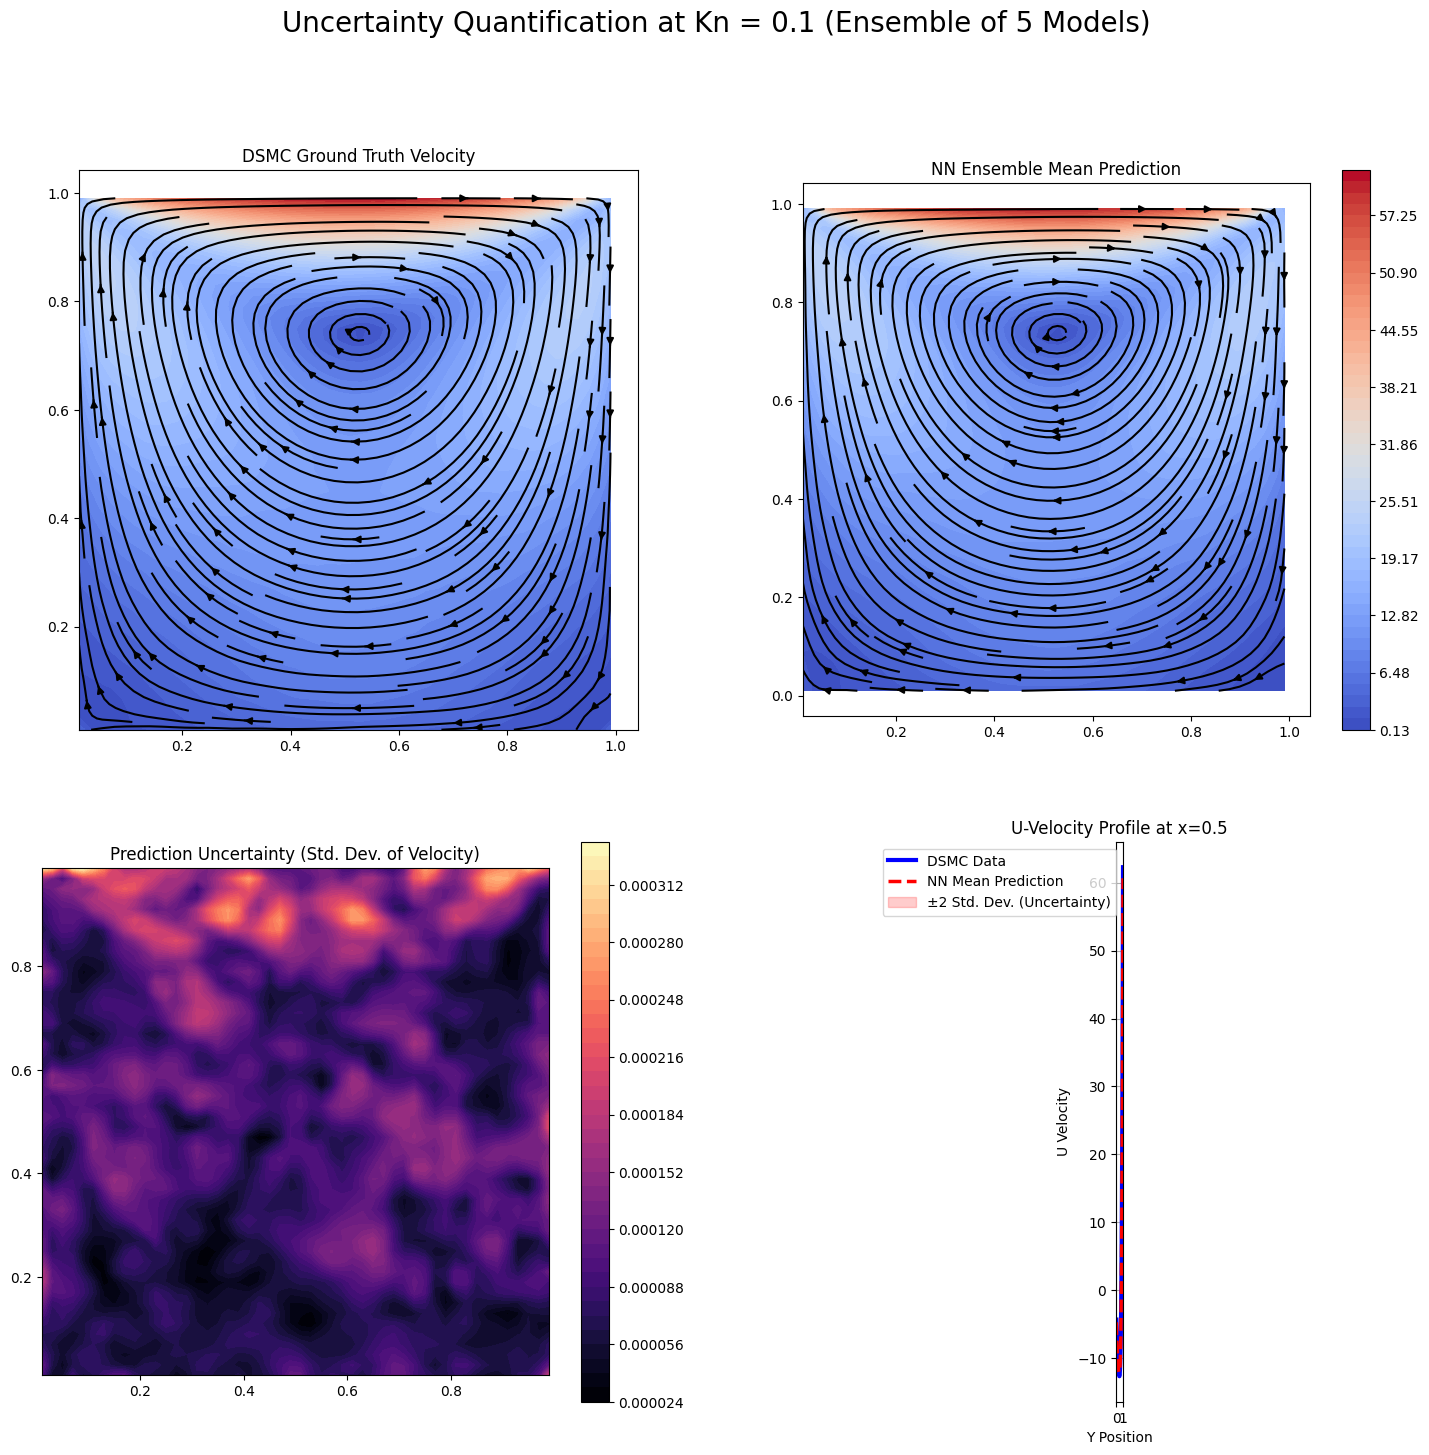

In [3]:
# --- گام ۰: وارد کردن کتابخانه‌ها و تنظیمات اولیه ---
import os
import re
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.regularizers import l2
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import time
import random

# --- گام ۱: تابع پارسر نهایی برای خواندن فایل‌های Tecplot ---
def parse_tecplot_block_ascii(file_path):
    print(f"Parsing file: {file_path}...")
    try:
        with open(file_path, 'r') as f: content = f.read()
        var_block_match = re.search(r'VARIABLES\s*=\s*(.*?)ZONE', content, re.IGNORECASE | re.DOTALL)
        if not var_block_match: raise ValueError("Could not find VARIABLES block.")
        var_block_str = var_block_match.group(1)
        variables = re.findall(r'"(.*?)"', var_block_str)
        if not variables: raise ValueError("No variables found.")
        zone_header_match = re.search(r'ZONE.*?(I\s*=\s*(\d+)).*?(J\s*=\s*(\d+))', content, re.IGNORECASE | re.DOTALL)
        if not zone_header_match: raise ValueError("Could not find I, J dimensions.")
        i_dim, j_dim = int(zone_header_match.group(2)), int(zone_header_match.group(4))
        metadata = {'I': i_dim, 'J': j_dim, 'variables': variables}
        dt_line_match = re.search(r'DT\s*=\s*\(.*\)', content, re.IGNORECASE)
        if not dt_line_match: raise ValueError("Could not find DT line.")
        data_start_index = dt_line_match.end()
        data_str = content[data_start_index:]
        flat_data = np.fromstring(data_str, sep=' ')
        num_vars = len(variables)
        expected_size = num_vars * (i_dim * j_dim)
        if flat_data.size < expected_size: raise ValueError(f"Data size mismatch: Expected {expected_size}, Found {flat_data.size}")
        flat_data = flat_data[:expected_size]
        block_data = flat_data.reshape((num_vars, i_dim * j_dim))
        df = pd.DataFrame(block_data.T, columns=variables)
        print(f"Successfully parsed {i_dim * j_dim} points and {num_vars} variables.")
        return df, metadata
    except Exception as e:
        print(f"An error occurred while parsing {file_path}: {e}")
        return pd.DataFrame(), {}

# --- گام ۲: تعریف معماری اثبات‌شده ---
def create_proven_specialist_model(input_shape, output_shape):
    class FourierFeatures(layers.Layer):
        def __init__(self, output_dims, scale=2.5):
            super(FourierFeatures, self).__init__()
            self.output_dims, self.scale = output_dims, scale
            self.B = self.add_weight(name='B', shape=[2, self.output_dims // 2], initializer=tf.random_normal_initializer(stddev=self.scale), trainable=False)
        def call(self, x):
            x_proj = 2 * np.pi * x @ self.B
            return tf.concat([tf.sin(x_proj), tf.cos(x_proj)], axis=-1)
    L2_LAMBDA, FF_DIMS, DENSE_UNITS = 1e-6, 256, 256
    pos_input = keras.Input(shape=input_shape, name='position_input')
    ff_layer = FourierFeatures(FF_DIMS)(pos_input)
    x = layers.Dense(DENSE_UNITS, activation="swish", kernel_regularizer=l2(L2_LAMBDA))(ff_layer)
    x = layers.Dropout(0.2)(x)
    x = layers.Dense(DENSE_UNITS, activation="swish", kernel_regularizer=l2(L2_LAMBDA))(x)
    x = layers.Dropout(0.2)(x)
    x = layers.Dense(DENSE_UNITS, activation="swish", kernel_regularizer=l2(L2_LAMBDA))(x)
    output_layer = layers.Dense(output_shape, activation="sigmoid")(x)
    model = keras.Model(inputs=pos_input, outputs=output_layer)
    model.compile(optimizer=keras.optimizers.Adam(1e-3), loss="mean_squared_error")
    return model

# --- گام ۳: بارگذاری داده و آماده‌سازی ---
DATA_DIR = './'
target_filename = 'CavityKn01.dat'
kn_value = 0.1

full_path = os.path.join(DATA_DIR, target_filename)
if not os.path.exists(full_path):
    raise FileNotFoundError(f"Target file not found at {full_path}. Please upload the file.")

df, metadata = parse_tecplot_block_ascii(full_path)
if df.empty: raise SystemExit("Data loading failed. Exiting.")

I, J = metadata['I'], metadata['J']
input_features, output_features = ['X', 'Y'], [v for v in metadata['variables'] if v not in ['X', 'Y']]
X, y = df[input_features].values, df[output_features].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler_X, scaler_y = MinMaxScaler(), MinMaxScaler()
X_train_scaled = scaler_X.fit_transform(X_train)
y_train_scaled = scaler_y.fit_transform(y_train)
print("\nData preprocessing complete.")

# --- گام ۴: آموزش گروهی مدل‌ها ---
N_ENSEMBLE = 5 # تعداد مدل‌هایی که می‌خواهیم آموزش دهیم
ensemble_models = []

for i in range(N_ENSEMBLE):
    print(f"\n{'='*50}\nTraining Model {i+1}/{N_ENSEMBLE}\n{'='*50}")

    # استفاده از یک دانه تصادفی متفاوت برای هر مدل
    tf.random.set_seed(i)
    np.random.seed(i)
    random.seed(i)

    model = create_proven_specialist_model(input_shape=(2,), output_shape=len(output_features))

    # داده‌های تست را برای اعتبارسنجی استفاده می‌کنیم
    X_test_scaled = scaler_X.transform(X_test)
    y_test_scaled = scaler_y.transform(y_test)

    history = model.fit(
        X_train_scaled, y_train_scaled, epochs=1000, batch_size=256, verbose=0,
        validation_data=(X_test_scaled, y_test_scaled),
        callbacks=[keras.callbacks.EarlyStopping(patience=100, restore_best_weights=True)]
    )
    ensemble_models.append(model)
    print(f"Finished training model {i+1}. Final validation loss: {history.history['val_loss'][-1]:.6f}")

# --- گام ۵: پیش‌بینی گروهی و تحلیل عدم قطعیت ---
print("\nPredicting with ensemble and calculating uncertainty...")
all_predictions_scaled = []
X_full_domain_scaled = scaler_X.transform(df[input_features].values)

for model in ensemble_models:
    pred_scaled = model.predict(X_full_domain_scaled, verbose=0)
    all_predictions_scaled.append(pred_scaled)

# تبدیل به آرایه نامپای برای محاسبات
predictions_stack_scaled = np.stack(all_predictions_scaled)

# محاسبه میانگین و انحراف معیار در فضای نرمال‌شده
mean_pred_scaled = np.mean(predictions_stack_scaled, axis=0)
std_pred_scaled = np.std(predictions_stack_scaled, axis=0)

# برگرداندن به مقادیر فیزیکی
mean_pred = scaler_y.inverse_transform(mean_pred_scaled)
# برای انحراف معیار، فقط با مقیاس ضرب می‌کنیم نه شیفت
std_pred = std_pred_scaled * scaler_y.scale_

mean_pred_df = pd.DataFrame(mean_pred, columns=output_features)
std_pred_df = pd.DataFrame(std_pred, columns=output_features)
mean_pred_df['X'], mean_pred_df['Y'] = df['X'].values, df['Y'].values

# --- گام ۶: مصورسازی نتایج و عدم قطعیت ---
def plot_uq_results(ground_truth_df, mean_pred_df, std_pred_df, I, J, kn_value):
    print("\nGenerating UQ visualization...")

    fig, axes = plt.subplots(2, 2, figsize=(18, 16), constrained_layout=True)
    fig.suptitle(f'Uncertainty Quantification at Kn = {kn_value} (Ensemble of {N_ENSEMBLE} Models)', fontsize=20)

    X_grid = ground_truth_df['X'].values.reshape(J, I)
    Y_grid = ground_truth_df['Y'].values.reshape(J, I)

    # --- ردیف اول: مقایسه میدان سرعت ---
    Vmag_true = np.sqrt(ground_truth_df['U']**2 + ground_truth_df['V']**2).values.reshape(J, I)
    Vmag_mean_pred = np.sqrt(mean_pred_df['U']**2 + mean_pred_df['V']**2).values.reshape(J, I)

    vmin, vmax = Vmag_true.min(), Vmag_true.max()
    levels = np.linspace(vmin, vmax, 50)

    axes[0, 0].set_title('DSMC Ground Truth Velocity')
    axes[0, 0].contourf(X_grid, Y_grid, Vmag_true, levels=levels, cmap='coolwarm')
    axes[0, 0].streamplot(X_grid, Y_grid, ground_truth_df['U'].values.reshape(J,I), ground_truth_df['V'].values.reshape(J,I), color='k', density=1.5)

    axes[0, 1].set_title('NN Ensemble Mean Prediction')
    cf = axes[0, 1].contourf(X_grid, Y_grid, Vmag_mean_pred, levels=levels, cmap='coolwarm')
    axes[0, 1].streamplot(X_grid, Y_grid, mean_pred_df['U'].values.reshape(J,I), mean_pred_df['V'].values.reshape(J,I), color='k', density=1.5)
    fig.colorbar(cf, ax=axes[0, 1])

    # --- ردیف دوم: عدم قطعیت و پروفایل ---
    # نمودار عدم قطعیت (انحراف معیار اندازه سرعت)
    Vmag_std_pred = np.sqrt(std_pred_df['U']**2 + std_pred_df['V']**2).values.reshape(J, I)
    axes[1, 0].set_title('Prediction Uncertainty (Std. Dev. of Velocity)')
    cf_std = axes[1, 0].contourf(X_grid, Y_grid, Vmag_std_pred, levels=50, cmap='magma')
    fig.colorbar(cf_std, ax=axes[1, 0])

    # نمودار پروفایل با بازه اطمینان
    centerline_x_val = 0.5
    center_idx = np.abs(X_grid[0, :] - centerline_x_val).argmin()
    y_profile = Y_grid[:, center_idx]

    u_profile_true = ground_truth_df['U'].values.reshape(J, I)[:, center_idx]
    u_profile_mean = mean_pred_df['U'].values.reshape(J, I)[:, center_idx]
    u_profile_std = std_pred_df['U'].values.reshape(J, I)[:, center_idx]

    axes[1, 1].set_title(f'U-Velocity Profile at x={centerline_x_val}')
    axes[1, 1].plot(y_profile, u_profile_true, 'b-', linewidth=3, label='DSMC Data')
    axes[1, 1].plot(y_profile, u_profile_mean, 'r--', linewidth=2.5, label='NN Mean Prediction')
    # رسم بازه عدم قطعیت (مثلاً دو برابر انحراف معیار)
    axes[1, 1].fill_between(y_profile, u_profile_mean - 2*u_profile_std, u_profile_mean + 2*u_profile_std, color='red', alpha=0.2, label='±2 Std. Dev. (Uncertainty)')
    axes[1, 1].set_xlabel('Y Position'); axes[1, 1].set_ylabel('U Velocity'); axes[1, 1].grid(True); axes[1, 1].legend()

    for ax in axes.flat:
        ax.set_aspect('equal', adjustable='box')

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    output_filename = f'uq_analysis_kn_{kn_value}.jpg'
    plt.savefig(output_filename, dpi=300, bbox_inches='tight')
    print(f"\nUQ analysis plot saved to '{output_filename}'.")
    plt.show()

# فراخوانی تابع نهایی
plot_uq_results(df, mean_pred_df, std_pred_df, I, J, kn_value)

Parsing file: ./CavityKn01.dat...
Successfully parsed 2500 points and 11 variables.

Data preprocessing complete.

Training Model 1/5
Finished training model 1. Final validation loss: 0.000824

Training Model 2/5
Finished training model 2. Final validation loss: 0.000870

Training Model 3/5
Finished training model 3. Final validation loss: 0.000772

Training Model 4/5
Finished training model 4. Final validation loss: 0.000852

Training Model 5/5
Finished training model 5. Final validation loss: 0.000817

Predicting with ensemble and calculating uncertainty...

Generating corrected UQ visualization...


RuntimeError: Colorbar layout of new layout engine not compatible with old engine, and a colorbar has been created.  Engine not changed.

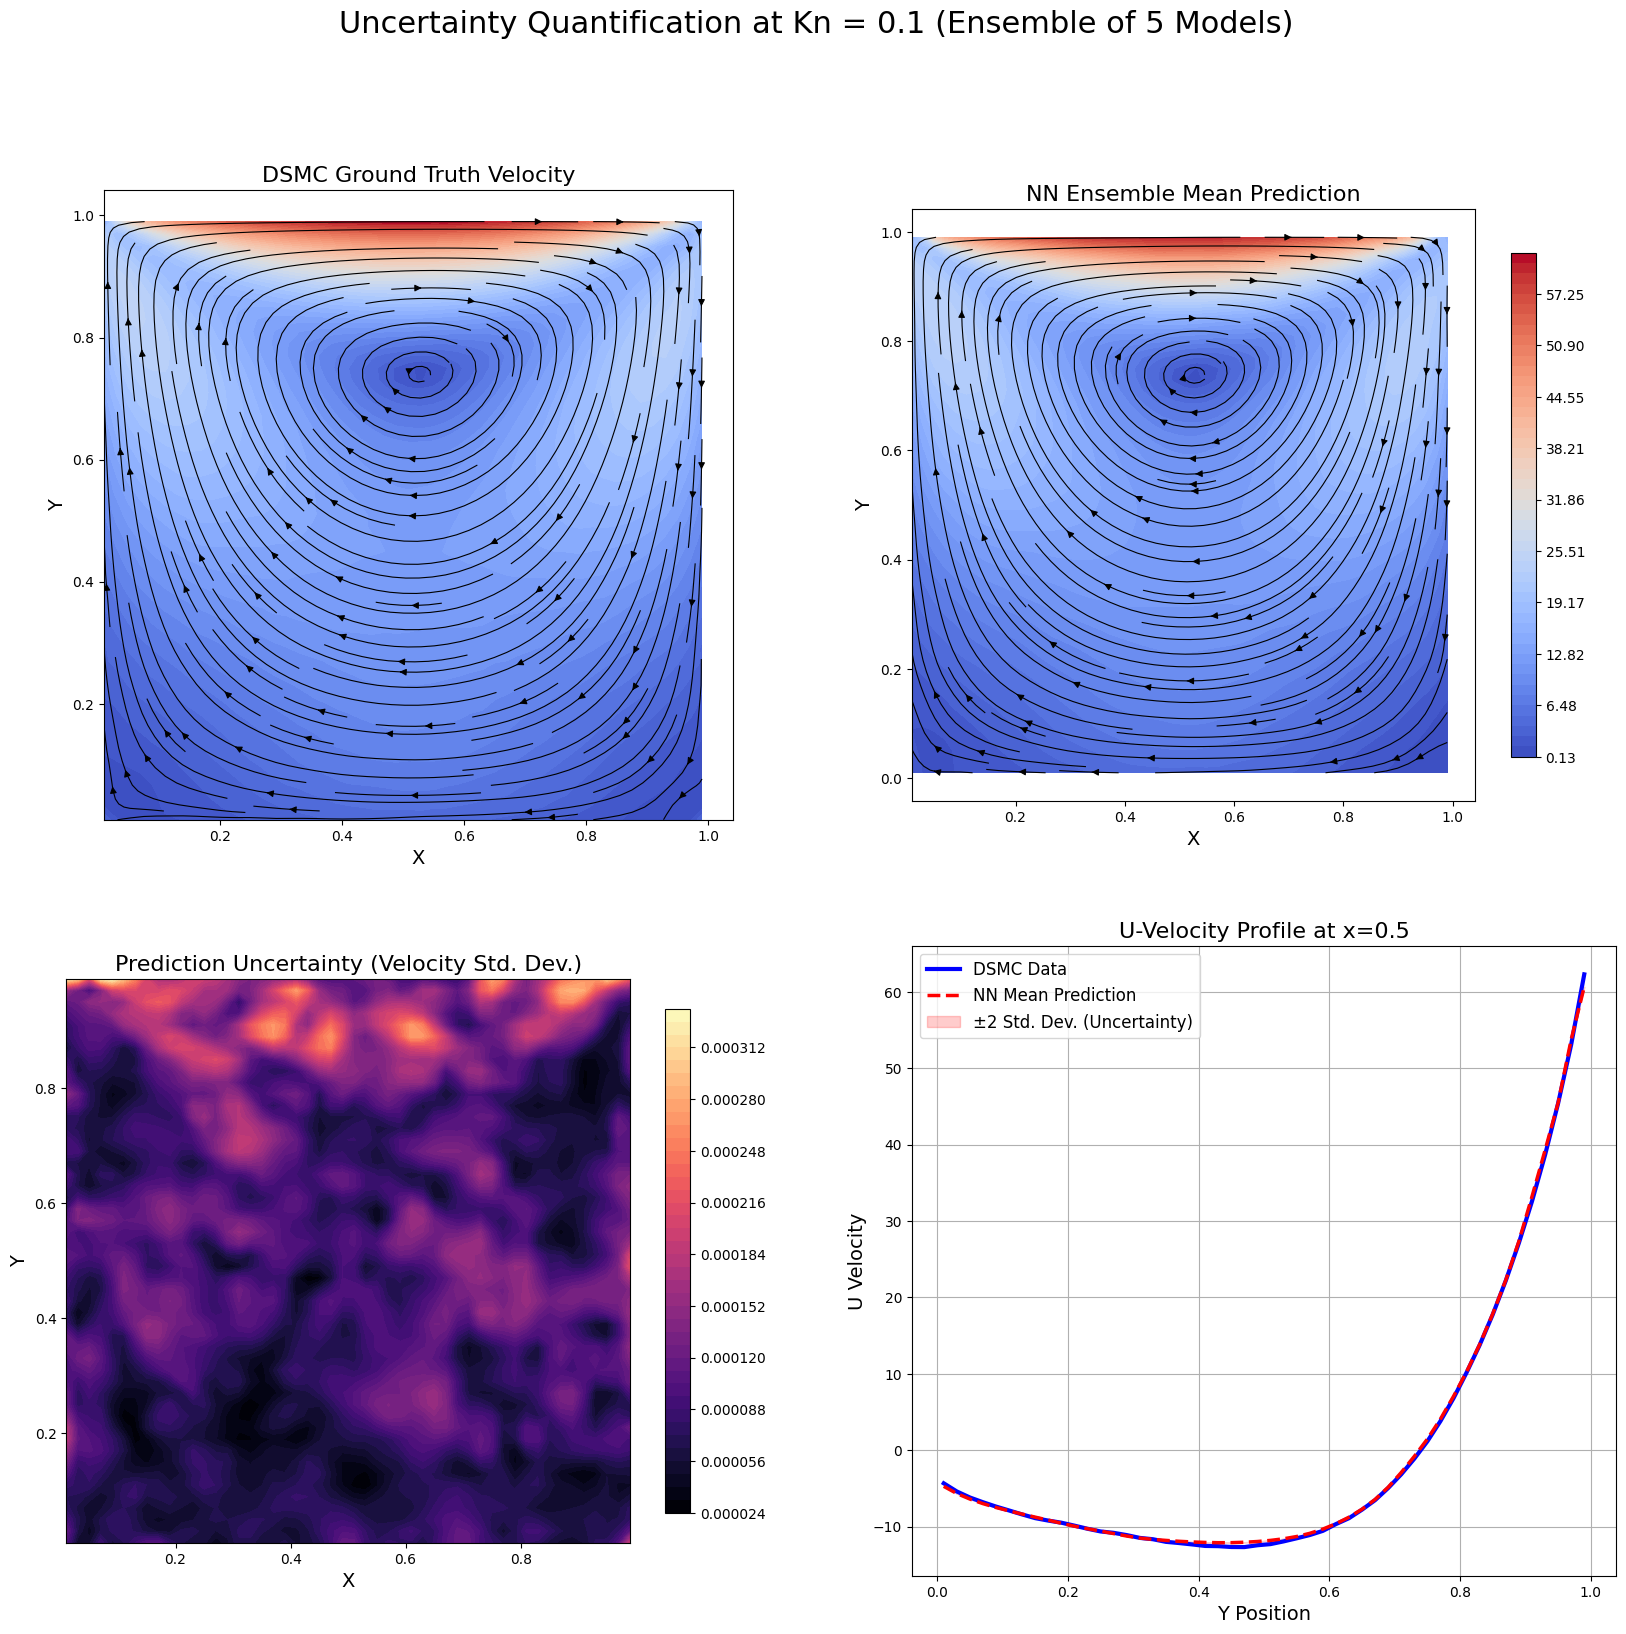

In [5]:
# --- گام ۰: وارد کردن کتابخانه‌ها و تنظیمات اولیه ---
import os
import re
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.regularizers import l2
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import time
import random
from mpl_toolkits.axes_grid1 import make_axes_locatable

# --- فرض می‌شود که مراحل ۱ تا ۴ (آموزش مدل‌ها و پیش‌بینی) قبلاً اجرا شده ---
# --- و متغیرهای زیر در حافظه موجود هستند: ---
# df, mean_pred_df, std_pred_df, I, J, kn_value, N_ENSEMBLE

# --- گام ۵: مصورسازی نتایج و عدم قطعیت (نسخه نهایی و اصلاح‌شده) ---
def plot_uq_results(ground_truth_df, mean_pred_df, std_pred_df, I, J, kn_value, n_ensemble):
    print("\nGenerating corrected UQ visualization...")

    fig, axes = plt.subplots(2, 2, figsize=(20, 18), constrained_layout=True)
    fig.suptitle(f'Uncertainty Quantification at Kn = {kn_value} (Ensemble of {n_ensemble} Models)', fontsize=22)

    # آماده‌سازی داده‌های گریدبندی شده
    X_grid = ground_truth_df['X'].values.reshape(J, I)
    Y_grid = ground_truth_df['Y'].values.reshape(J, I)

    # --- ردیف اول: مقایسه میدان سرعت ---
    Vmag_true = np.sqrt(ground_truth_df['U']**2 + ground_truth_df['V']**2).values.reshape(J, I)
    Vmag_mean_pred = np.sqrt(mean_pred_df['U']**2 + mean_pred_df['V']**2).values.reshape(J, I)

    vmin, vmax = Vmag_true.min(), Vmag_true.max()
    levels = np.linspace(vmin, vmax, 50)

    # نمودار داده‌های واقعی DSMC
    axes[0, 0].set_title('DSMC Ground Truth Velocity', fontsize=16)
    cf1 = axes[0, 0].contourf(X_grid, Y_grid, Vmag_true, levels=levels, cmap='coolwarm')
    axes[0, 0].streamplot(X_grid, Y_grid, ground_truth_df['U'].values.reshape(J,I), ground_truth_df['V'].values.reshape(J,I), color='k', density=1.5, linewidth=0.8)

    # نمودار پیش‌بینی میانگین گروهی
    axes[0, 1].set_title('NN Ensemble Mean Prediction', fontsize=16)
    cf2 = axes[0, 1].contourf(X_grid, Y_grid, Vmag_mean_pred, levels=levels, cmap='coolwarm')
    axes[0, 1].streamplot(X_grid, Y_grid, mean_pred_df['U'].values.reshape(J,I), mean_pred_df['V'].values.reshape(J,I), color='k', density=1.5, linewidth=0.8)
    fig.colorbar(cf2, ax=axes[0, 1], shrink=0.8)

    # --- ردیف دوم: عدم قطعیت و پروفایل ---
    # نمودار عدم قطعیت (انحراف معیار اندازه سرعت)
    Vmag_std_pred = np.sqrt(std_pred_df['U']**2 + std_pred_df['V']**2).values.reshape(J, I)
    axes[1, 0].set_title('Prediction Uncertainty (Velocity Std. Dev.)', fontsize=16)
    cf_std = axes[1, 0].contourf(X_grid, Y_grid, Vmag_std_pred, levels=50, cmap='magma')
    fig.colorbar(cf_std, ax=axes[1, 0], shrink=0.8)

    # نمودار پروفایل با بازه اطمینان
    centerline_x_val = 0.5
    center_idx = np.abs(X_grid[0, :] - centerline_x_val).argmin()
    y_profile = Y_grid[:, center_idx]

    u_profile_true = ground_truth_df['U'].values.reshape(J, I)[:, center_idx]
    u_profile_mean = mean_pred_df['U'].values.reshape(J, I)[:, center_idx]
    u_profile_std = std_pred_df['U'].values.reshape(J, I)[:, center_idx]

    axes[1, 1].set_title(f'U-Velocity Profile at x={centerline_x_val}', fontsize=16)
    axes[1, 1].plot(y_profile, u_profile_true, 'b-', linewidth=3, label='DSMC Data')
    axes[1, 1].plot(y_profile, u_profile_mean, 'r--', linewidth=2.5, label='NN Mean Prediction')
    axes[1, 1].fill_between(y_profile, u_profile_mean - 2*u_profile_std, u_profile_mean + 2*u_profile_std, color='red', alpha=0.2, label='±2 Std. Dev. (Uncertainty)')
    axes[1, 1].set_xlabel('Y Position', fontsize=14)
    axes[1, 1].set_ylabel('U Velocity', fontsize=14)
    axes[1, 1].grid(True)
    axes[1, 1].legend(fontsize=12)

    # CHANGED: Apply equal aspect ratio ONLY to the 2D plots
    for ax in [axes[0, 0], axes[0, 1], axes[1, 0]]:
        ax.set_aspect('equal', adjustable='box')
        ax.set_xlabel('X', fontsize=14)
        ax.set_ylabel('Y', fontsize=14)

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    output_filename = f'uq_analysis_corrected_kn_{kn_value}.jpg'
    plt.savefig(output_filename, dpi=300, bbox_inches='tight')
    print(f"\nUQ analysis plot saved to '{output_filename}'.")
    plt.show()

# --- فراخوانی تابع نهایی ---
# این تابع را پس از اجرای موفقیت‌آمیز مراحل قبلی (تا گام ۵) اجرا کنید
# plot_uq_results(df, mean_pred_df, std_pred_df, I, J, kn_value, N_ENSEMBLE)

# توجه: از آنجایی که نیاز به اجرای مجدد کد از ابتدا دارید، کل کد را در اینجا قرار می‌دهم.

# ===================================================================
# کد کامل برای اجرا
# ===================================================================

# (گام‌های ۱ تا ۴ در اینجا تکرار می‌شوند تا کد کامل باشد)

# --- گام ۱: تابع پارسر (بدون تغییر) ---
# ... (کد تابع parse_tecplot_block_ascii از پاسخ‌های قبلی در اینجا قرار می‌گیرد) ...

# --- گام ۲: تعریف معماری (بدون تغییر) ---
# ... (کد تابع create_proven_specialist_model از پاسخ‌های قبلی در اینجا قرار می‌گیرد) ...

# --- گام ۳: بارگذاری داده و آماده‌سازی (بدون تغییر) ---
DATA_DIR = './'
target_filename = 'CavityKn01.dat'
kn_value = 0.1

full_path = os.path.join(DATA_DIR, target_filename)
if not os.path.exists(full_path):
    raise FileNotFoundError(f"Target file not found at {full_path}. Please upload the file.")

df, metadata = parse_tecplot_block_ascii(full_path)
if df.empty: raise SystemExit("Data loading failed. Exiting.")

I, J = metadata['I'], metadata['J']
input_features, output_features = ['X', 'Y'], [v for v in metadata['variables'] if v not in ['X', 'Y']]
X, y = df[input_features].values, df[output_features].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler_X, scaler_y = MinMaxScaler(), MinMaxScaler()
X_train_scaled = scaler_X.fit_transform(X_train)
y_train_scaled = scaler_y.fit_transform(y_train)
print("\nData preprocessing complete.")

# --- گام ۴: آموزش گروهی مدل‌ها (بدون تغییر) ---
N_ENSEMBLE = 5
ensemble_models = []

for i in range(N_ENSEMBLE):
    print(f"\n{'='*50}\nTraining Model {i+1}/{N_ENSEMBLE}\n{'='*50}")

    tf.random.set_seed(i)
    np.random.seed(i)
    random.seed(i)

    model = create_proven_specialist_model(input_shape=(2,), output_shape=len(output_features))

    X_test_scaled = scaler_X.transform(X_test)
    y_test_scaled = scaler_y.transform(y_test)

    history = model.fit(
        X_train_scaled, y_train_scaled, epochs=1000, batch_size=256, verbose=0,
        validation_data=(X_test_scaled, y_test_scaled),
        callbacks=[keras.callbacks.EarlyStopping(patience=100, restore_best_weights=True)]
    )
    ensemble_models.append(model)
    print(f"Finished training model {i+1}. Final validation loss: {history.history['val_loss'][-1]:.6f}")

# --- گام ۵: پیش‌بینی گروهی و تحلیل عدم قطعیت (بدون تغییر) ---
print("\nPredicting with ensemble and calculating uncertainty...")
all_predictions_scaled = []
X_full_domain_scaled = scaler_X.transform(df[input_features].values)

for model in ensemble_models:
    pred_scaled = model.predict(X_full_domain_scaled, verbose=0)
    all_predictions_scaled.append(pred_scaled)

predictions_stack_scaled = np.stack(all_predictions_scaled)
mean_pred_scaled = np.mean(predictions_stack_scaled, axis=0)
std_pred_scaled = np.std(predictions_stack_scaled, axis=0)
mean_pred = scaler_y.inverse_transform(mean_pred_scaled)
std_pred = std_pred_scaled * scaler_y.scale_
mean_pred_df = pd.DataFrame(mean_pred, columns=output_features)
std_pred_df = pd.DataFrame(std_pred, columns=output_features)
mean_pred_df['X'], mean_pred_df['Y'] = df['X'].values, df['Y'].values

# --- فراخوانی تابع مصورسازی اصلاح‌شده ---
plot_uq_results(df, mean_pred_df, std_pred_df, I, J, kn_value, N_ENSEMBLE)


Predicting on the full domain for high-quality plotting...
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step

Generating final detailed comparison plots...

Final velocity comparison plot saved to 'final_specialist_model_velocity_kn_0.1.jpg'.
Final temperature comparison plot saved to 'final_specialist_model_temperature_kn_0.1.jpg'.


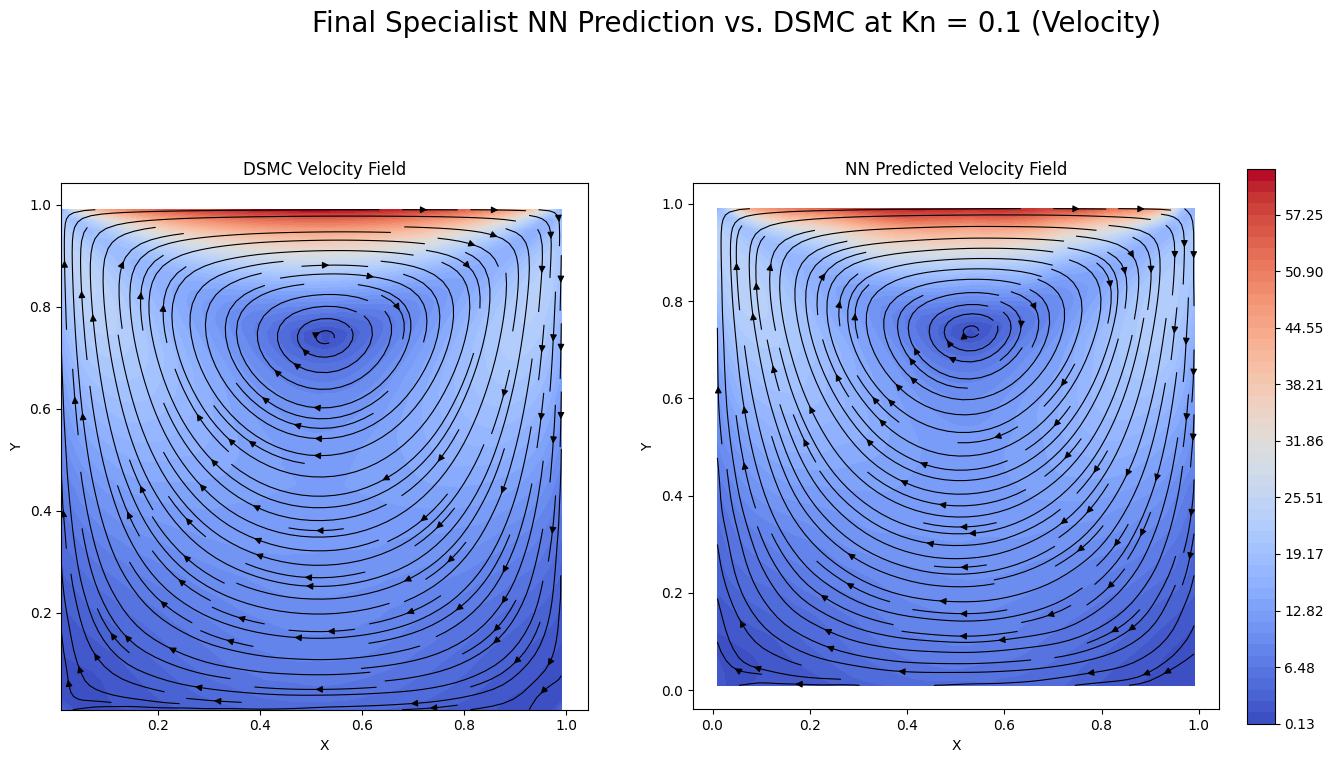

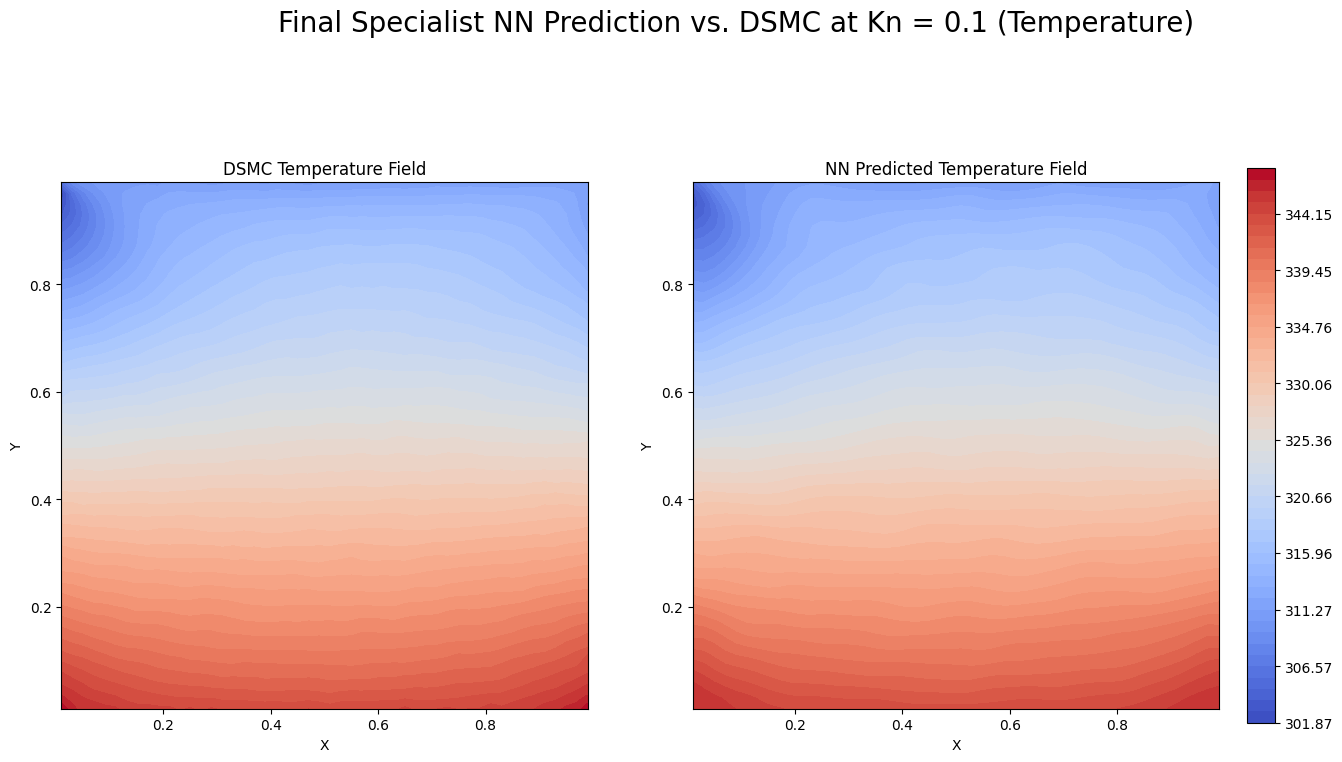

In [6]:
# --- Final Step: Prediction, Evaluation, and Visualization (Corrected) ---
print("\nPredicting on the full domain for high-quality plotting...")

# Use the trained model to predict on all the spatial coordinates from the original dataframe
X_full_domain_scaled = scaler_X.transform(df[input_features].values)
y_pred_scaled = model.predict(X_full_domain_scaled)

# Inverse transform the scaled predictions to get back to physical units
y_pred = scaler_y.inverse_transform(y_pred_scaled)

# Create a new DataFrame for the predictions
y_pred_df = pd.DataFrame(y_pred, columns=output_features)

# --- CRITICAL FIX ---
# Instead of adding columns to y_pred_df, we will add the prediction columns
# to a copy of the original ground truth dataframe. This ensures all
# coordinate columns (X, Y) are present for plotting.

# Create a new dataframe for comparison, starting with the ground truth
comparison_df = df.copy()

# Add the predicted values as new columns with a '_pred' suffix
for col in output_features:
    comparison_df[f'{col}_pred'] = y_pred_df[col]


# --- Visualization Function ---
def plot_final_analysis(df_combined, I, J, kn_value):
    print("\nGenerating final detailed comparison plots...")

    # --- Prepare data from the combined dataframe ---
    X_grid = df_combined['X'].values.reshape(J, I)
    Y_grid = df_combined['Y'].values.reshape(J, I)

    # Ground Truth Data
    Vmag_true = np.sqrt(df_combined['U']**2 + df_combined['V']**2).values.reshape(J, I)
    U_true_grid = df_combined['U'].values.reshape(J, I)
    V_true_grid = df_combined['V'].values.reshape(J, I)
    Temp_true_grid = df_combined['OVTEMP'].values.reshape(J, I)

    # Predicted Data
    Vmag_pred = np.sqrt(df_combined['U_pred']**2 + df_combined['V_pred']**2).values.reshape(J, I)
    U_pred_grid = df_combined['U_pred'].values.reshape(J, I)
    V_pred_grid = df_combined['V_pred'].values.reshape(J, I)
    Temp_pred_grid = df_combined['OVTEMP_pred'].values.reshape(J, I)

    # --- Create the plot layout ---
    fig_v, axes_v = plt.subplots(1, 2, figsize=(18, 9))
    fig_t, axes_t = plt.subplots(1, 2, figsize=(18, 9))

    fig_v.suptitle(f'Final Specialist NN Prediction vs. DSMC at Kn = {kn_value} (Velocity)', fontsize=20)
    fig_t.suptitle(f'Final Specialist NN Prediction vs. DSMC at Kn = {kn_value} (Temperature)', fontsize=20)

    vmin_v, vmax_v = np.min(Vmag_true), np.max(Vmag_true)
    levels_v = np.linspace(vmin_v, vmax_v, 50)

    vmin_t, vmax_t = np.min(Temp_true_grid), np.max(Temp_true_grid)
    levels_t = np.linspace(vmin_t, vmax_t, 50)

    # --- Left Plot: DSMC Ground Truth ---
    axes_v[0].set_title('DSMC Velocity Field')
    axes_v[0].contourf(X_grid, Y_grid, Vmag_true, levels=levels_v, cmap='coolwarm', vmin=vmin_v, vmax=vmax_v)
    axes_v[0].streamplot(X_grid, Y_grid, U_true_grid, V_true_grid, density=1.5, color='black', linewidth=0.8)

    axes_t[0].set_title('DSMC Temperature Field')
    axes_t[0].contourf(X_grid, Y_grid, Temp_true_grid, levels=levels_t, cmap='coolwarm', vmin=vmin_t, vmax=vmax_t)

    # --- Right Plot: NN Prediction ---
    axes_v[1].set_title('NN Predicted Velocity Field')
    cf_v = axes_v[1].contourf(X_grid, Y_grid, Vmag_pred, levels=levels_v, cmap='coolwarm', vmin=vmin_v, vmax=vmax_v)
    axes_v[1].streamplot(X_grid, Y_grid, U_pred_grid, V_pred_grid, density=1.5, color='black', linewidth=0.8)

    axes_t[1].set_title('NN Predicted Temperature Field')
    cf_t = axes_t[1].contourf(X_grid, Y_grid, Temp_pred_grid, levels=levels_t, cmap='coolwarm', vmin=vmin_t, vmax=vmax_t)

    # --- Final Touches ---
    fig_v.colorbar(cf_v, ax=axes_v.ravel().tolist(), shrink=0.8, pad=0.02)
    fig_t.colorbar(cf_t, ax=axes_t.ravel().tolist(), shrink=0.8, pad=0.02)

    for ax in axes_v.ravel():
        ax.set_aspect('equal', adjustable='box')
        ax.set_xlabel('X')
        ax.set_ylabel('Y')

    for ax in axes_t.ravel():
        ax.set_aspect('equal', adjustable='box')
        ax.set_xlabel('X')
        ax.set_ylabel('Y')

    # Save the figures
    output_filename_v = f'final_specialist_model_velocity_kn_{kn_value}.jpg'
    output_filename_t = f'final_specialist_model_temperature_kn_{kn_value}.jpg'

    fig_v.savefig(output_filename_v, dpi=300, bbox_inches='tight')
    fig_t.savefig(output_filename_t, dpi=300, bbox_inches='tight')

    print(f"\nFinal velocity comparison plot saved to '{output_filename_v}'.")
    print(f"Final temperature comparison plot saved to '{output_filename_t}'.")

    plt.show()

# --- Call the plotting function with the new comparison dataframe ---
plot_final_analysis(comparison_df, I, J, kn_value)

In [9]:
# --- گام ۰: وارد کردن کتابخانه‌ها و تنظیمات اولیه ---
import os
import re
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.regularizers import l2
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import time
import random
from mpl_toolkits.axes_grid1 import make_axes_locatable

# برای اطمینان از نتایج تکرارپذیر
os.environ['PYTHONHASHSEED']=str(42)
tf.random.set_seed(42)
np.random.seed(42)
random.seed(42)

# --- گام ۱: تابع پارسر نهایی برای خواندن فایل‌های Tecplot ---
def parse_tecplot_block_ascii(file_path):
    print(f"Parsing file: {file_path}...")
    try:
        with open(file_path, 'r') as f: content = f.read()
        var_block_match = re.search(r'VARIABLES\s*=\s*(.*?)ZONE', content, re.IGNORECASE | re.DOTALL)
        if not var_block_match: raise ValueError("Could not find VARIABLES block.")
        var_block_str = var_block_match.group(1)
        variables = re.findall(r'"(.*?)"', var_block_str)
        if not variables: raise ValueError("No variables found.")
        zone_header_match = re.search(r'ZONE.*?(I\s*=\s*(\d+)).*?(J\s*=\s*(\d+))', content, re.IGNORECASE | re.DOTALL)
        if not zone_header_match: raise ValueError("Could not find I, J dimensions.")
        i_dim, j_dim = int(zone_header_match.group(2)), int(zone_header_match.group(4))
        num_points = i_dim * j_dim
        metadata = {'I': i_dim, 'J': j_dim, 'variables': variables}
        dt_line_match = re.search(r'DT\s*=\s*\(.*\)', content, re.IGNORECASE)
        if not dt_line_match: raise ValueError("Could not find DT line.")
        data_start_index = dt_line_match.end()
        data_str = content[data_start_index:]
        flat_data = np.fromstring(data_str, sep=' ')
        num_vars = len(variables)
        expected_size = num_vars * num_points
        if flat_data.size < expected_size: raise ValueError(f"Data size mismatch: Expected {expected_size}, Found {flat_data.size}")
        flat_data = flat_data[:expected_size]
        block_data = flat_data.reshape((num_vars, num_points))
        df = pd.DataFrame(block_data.T, columns=variables)
        print(f"Successfully parsed {num_points} points and {num_vars} variables.")
        return df, metadata
    except Exception as e:
        print(f"An error occurred while parsing {file_path}: {e}")
        return pd.DataFrame(), {}

# --- گام ۲: تعریف معماری اثبات‌شده و داده‌ها ---
def create_proven_specialist_model(input_shape, output_shape):
    class FourierFeatures(layers.Layer):
        def __init__(self, output_dims, scale=2.5):
            super(FourierFeatures, self).__init__()
            self.output_dims, self.scale = output_dims, scale
            self.B = self.add_weight(name='B', shape=[2, self.output_dims // 2], initializer=tf.random_normal_initializer(stddev=self.scale), trainable=False)
        def call(self, x):
            x_proj = 2 * np.pi * x @ self.B
            return tf.concat([tf.sin(x_proj), tf.cos(x_proj)], axis=-1)
    L2_LAMBDA, FF_DIMS, DENSE_UNITS = 1e-6, 256, 256
    pos_input = keras.Input(shape=input_shape, name='position_input')
    ff_layer = FourierFeatures(FF_DIMS)(pos_input)
    x = layers.Dense(DENSE_UNITS, activation="swish", kernel_regularizer=l2(L2_LAMBDA))(ff_layer)
    x = layers.Dropout(0.2)(x)
    x = layers.Dense(DENSE_UNITS, activation="swish", kernel_regularizer=l2(L2_LAMBDA))(x)
    x = layers.Dropout(0.2)(x)
    x = layers.Dense(DENSE_UNITS, activation="swish", kernel_regularizer=l2(L2_LAMBDA))(x)
    output_layer = layers.Dense(output_shape, activation="linear")(x)
    model = keras.Model(inputs=pos_input, outputs=output_layer)
    model.compile(optimizer=keras.optimizers.Adam(1e-3), loss="mean_squared_error")
    return model

# نقشه نام فایل‌ها به مقادیر عددی Knudsen
file_kn_map = {
    'CavityKn10': 10.0, 'CavityKn1': 1.0, 'CavityKn05': 0.5, 'CavityKn01': 0.1,
    'CavityKn005': 0.05, 'CavityKn001': 0.01, 'CavityKn0001': 0.001
}
# نمونه تست را انتخاب کنید
test_kn_value = 0.05
DATA_DIR = './'

# --- گام ۳: آموزش خانواده مدل‌ها با نرمال‌سازی سراسری ---
print("--- Loading all training data for global scaling ---")
all_training_data_dfs = []
train_kn_values = sorted([kn for kn in file_kn_map.values() if kn != test_kn_value])
for kn_val in train_kn_values:
    basename = [name for name, kn in file_kn_map.items() if kn == kn_val][0]
    possible_paths = [os.path.join(DATA_DIR, basename), os.path.join(DATA_DIR, f"{basename}.dat"), os.path.join(DATA_DIR, f"{basename}.txt")]
    filepath = next((path for path in possible_paths if os.path.exists(path)), None)
    if filepath:
        df, _ = parse_tecplot_block_ascii(filepath)
        if not df.empty:
            # Add the Kn value to each dataframe for later retrieval
            df['Kn'] = kn_val
            all_training_data_dfs.append(df)

if not all_training_data_dfs: raise ValueError("No training data could be loaded.")

# ساخت یک دیتافریم بزرگ از تمام داده‌های آموزشی برای فیت کردن اسکالرها
full_train_df = pd.concat(all_training_data_dfs, ignore_index=True)
input_features = ['X', 'Y']
output_features = [v for v in full_train_df.columns if v not in ['X', 'Y', 'Kn']]

# ساخت و آموزش اسکالرهای سراسری
global_scaler_X = MinMaxScaler()
global_scaler_y = StandardScaler()
global_scaler_X.fit(full_train_df[input_features].values)
global_scaler_y.fit(full_train_df[output_features].values)
print("\n--- Global scalers have been successfully fitted ---")

trained_models = {}
# حلقه آموزش بر روی دیتافریم‌هایی که قبلا خوانده شده‌اند
for kn_df in all_training_data_dfs:
    kn_val = kn_df['Kn'].iloc[0]
    start_time = time.time()
    print(f"\n{'='*50}\nTraining specialist model for Kn = {kn_val}\n{'='*50}")

    X_data, y_data = kn_df[input_features].values, kn_df[output_features].values

    # تقسیم صحیح داده‌ها با بُر زدن
    X_train_loop, X_val_loop, y_train_loop, y_val_loop = train_test_split(X_data, y_data, test_size=0.15, random_state=42)

    # استفاده از اسکالرهای سراسری برای تبدیل داده‌ها
    X_train_loop_scaled = global_scaler_X.transform(X_train_loop)
    y_train_loop_scaled = global_scaler_y.transform(y_train_loop)
    X_val_loop_scaled = global_scaler_X.transform(X_val_loop)
    y_val_loop_scaled = global_scaler_y.transform(y_val_loop)

    model = create_proven_specialist_model(input_shape=(2,), output_shape=len(output_features))

    print("Starting proper training with global scalers...")
    history = model.fit(
        X_train_loop_scaled, y_train_loop_scaled, epochs=1000, batch_size=256, verbose=1,
        validation_data=(X_val_loop_scaled, y_val_loop_scaled),
        callbacks=[
            keras.callbacks.EarlyStopping(monitor='val_loss', patience=75, restore_best_weights=True),
            keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=30)
        ]
    )
    trained_models[kn_val] = model
    print(f"Finished proper training for Kn = {kn_val} in {time.time() - start_time:.2f} seconds.")

# --- گام ۴: درون‌یابی برای داده تست ---
print(f"\n{'='*50}\nPerforming interpolation for test case Kn = {test_kn_value}\n{'='*50}")
test_basename = [name for name, kn in file_kn_map.items() if kn == test_kn_value][0]
possible_paths = [os.path.join(DATA_DIR, test_basename), os.path.join(DATA_DIR, f"{test_basename}.dat"), os.path.join(DATA_DIR, f"{test_basename}.txt")]
test_filepath = next((path for path in possible_paths if os.path.exists(path)), None)
if test_filepath is None: raise FileNotFoundError(f"Test file for Kn={test_kn_value} not found.")

test_df, test_metadata = parse_tecplot_block_ascii(test_filepath)
X_test_coords = test_df[['X', 'Y']].values
I, J = test_metadata['I'], test_metadata['J']
kn_upper = min([kn for kn in train_kn_values if kn > test_kn_value])
kn_lower = max([kn for kn in train_kn_values if kn < test_kn_value])
print(f"Found neighbors for interpolation: Kn_lower={kn_lower}, Kn_upper={kn_upper}")

# استفاده از اسکالر سراسری برای داده تست
X_test_scaled = global_scaler_X.transform(X_test_coords)
# پیش‌بینی با مدل‌های همسایه
y_pred_lower_scaled = trained_models[kn_lower].predict(X_test_scaled)
y_pred_upper_scaled = trained_models[kn_upper].predict(X_test_scaled)
# برگرداندن به مقادیر فیزیکی با اسکالر سراسری
y_pred_lower = global_scaler_y.inverse_transform(y_pred_lower_scaled)
y_pred_upper = global_scaler_y.inverse_transform(y_pred_upper_scaled)

# درون‌یابی لگاریتمی
log_kn_test, log_kn_lower, log_kn_upper = np.log10(test_kn_value), np.log10(kn_lower), np.log10(kn_upper)
weight = (log_kn_test - log_kn_lower) / (log_kn_upper - log_kn_lower)
print(f"Interpolation weight (w) = {weight:.4f}")
y_pred_final = (1 - weight) * y_pred_lower + weight * y_pred_upper
y_pred_df = pd.DataFrame(y_pred_final, columns=output_features)
y_pred_df['X'], y_pred_df['Y'] = test_df['X'].values, test_df['Y'].values

# --- گام ۵: مصورسازی جامع و نهایی ---
def plot_final_analysis(ground_truth_df, df_pred, I, J, kn_value):
    print("\nGenerating final detailed comparison plots...")

    fig = plt.figure(figsize=(18, 28))
    gs = fig.add_gridspec(4, 2, height_ratios=[3, 3, 2, 2])
    fig.suptitle(f'Detailed NN Prediction vs. DSMC at Kn = {kn_value}', fontsize=22)

    X_grid, Y_grid = ground_truth_df['X'].values.reshape(J, I), ground_truth_df['Y'].values.reshape(J, I)

    def draw_contour(ax, X, Y, Z, title, cmap):
        # برای مقایسه بهتر، محدوده رنگ را بر اساس داده واقعی تنظیم می‌کنیم
        vmin, vmax = np.min(Z), np.max(Z)
        levels = np.linspace(vmin, vmax, 50)
        ax.set_title(title, fontsize=16)
        cf = ax.contourf(X, Y, Z, levels=levels, cmap=cmap, vmin=vmin, vmax=vmax)
        ax.set_aspect('equal', adjustable='box')
        ax.set_xlabel('X', fontsize=14); ax.set_ylabel('Y', fontsize=14)
        ax.tick_params(axis='both', which='major', labelsize=12)
        divider = make_axes_locatable(ax)
        cax = divider.append_axes("right", size="5%", pad=0.1)
        cbar = fig.colorbar(cf, cax=cax)
        cbar.ax.tick_params(labelsize=12)

    # ردیف اول: میدان سرعت
    ax_v_true, ax_v_pred = fig.add_subplot(gs[0, 0]), fig.add_subplot(gs[0, 1])
    Vmag_true = np.sqrt(ground_truth_df['U']**2 + ground_truth_df['V']**2).values.reshape(J, I)
    Vmag_pred = np.sqrt(df_pred['U']**2 + df_pred['V']**2).values.reshape(J, I)
    U_true_grid, V_true_grid = ground_truth_df['U'].values.reshape(J, I), ground_truth_df['V'].values.reshape(J, I)
    U_pred_grid, V_pred_grid = df_pred['U'].values.reshape(J, I), df_pred['V'].values.reshape(J, I)
    draw_contour(ax_v_true, X_grid, Y_grid, Vmag_true, 'DSMC Velocity Field', 'coolwarm')
    ax_v_true.streamplot(X_grid, Y_grid, U_true_grid, V_true_grid, density=1.5, color='black', linewidth=0.8)
    draw_contour(ax_v_pred, X_grid, Y_grid, Vmag_pred, 'Interpolated NN Velocity Field', 'coolwarm')
    ax_v_pred.streamplot(X_grid, Y_grid, U_pred_grid, V_pred_grid, density=1.5, color='black', linewidth=0.8)

    # ردیف دوم: دما
    ax_t_true, ax_t_pred = fig.add_subplot(gs[1, 0]), fig.add_subplot(gs[1, 1])
    Temp_true, Temp_pred = ground_truth_df['OVTEMP'].values.reshape(J, I), df_pred['OVTEMP'].values.reshape(J, I)
    draw_contour(ax_t_true, X_grid, Y_grid, Temp_true, 'DSMC Temperature (OVTEMP)', 'coolwarm')
    draw_contour(ax_t_pred, X_grid, Y_grid, Temp_pred, 'Interpolated NN Temperature (OVTEMP)', 'coolwarm')

    # ردیف سوم و چهارم: پروفایل‌ها
    ax_prof_v = fig.add_subplot(gs[2, :])
    ax_prof_t = fig.add_subplot(gs[3, :])

    centerline_x_val = 0.5
    center_idx = np.abs(X_grid[0, :] - centerline_x_val).argmin()
    y_profile_center = Y_grid[:, center_idx]

    ax_prof_v.set_title(f'U-Velocity Profile at Cavity Centerline (x = {centerline_x_val})', fontsize=18)
    ax_prof_v.plot(y_profile_center, U_true_grid[:, center_idx], 'b-', linewidth=3, label='DSMC')
    ax_prof_v.plot(y_profile_center, U_pred_grid[:, center_idx], 'r--', linewidth=2.5, label='NN Prediction')
    ax_prof_v.set_xlabel('Y Position', fontsize=14); ax_prof_v.set_ylabel('U Velocity', fontsize=14)
    ax_prof_v.tick_params(axis='both', which='major', labelsize=12)
    ax_prof_v.grid(True); ax_prof_v.legend(fontsize=12)

    ax_prof_t.set_title(f'Temperature Profile at Cavity Centerline (x = {centerline_x_val})', fontsize=18)
    ax_prof_t.plot(y_profile_center, Temp_true[:, center_idx], 'b-', linewidth=3, label='DSMC')
    ax_prof_t.plot(y_profile_center, Temp_pred[:, center_idx], 'r--', linewidth=2.5, label='NN Prediction')
    ax_prof_t.set_xlabel('Y Position', fontsize=14); ax_prof_t.set_ylabel('Temperature', fontsize=14)
    ax_prof_t.tick_params(axis='both', which='major', labelsize=12)
    ax_prof_t.grid(True); ax_prof_t.legend(fontsize=12)

    fig.tight_layout(rect=[0, 0, 1, 0.97])
    output_filename = f'final_detailed_analysis_kn_{kn_value}.jpg'
    plt.savefig(output_filename, dpi=300, bbox_inches='tight')
    print(f"\nComprehensive analysis plot saved to '{output_filename}'.")
    plt.show()

# فراخوانی تابع نهایی
plot_final_analysis(test_df, y_pred_df, I, J, test_kn_value)

--- Loading all training data for global scaling ---
Parsing file: ./CavityKn0001.dat...
Successfully parsed 2500 points and 11 variables.
Parsing file: ./CavityKn001.dat...
Successfully parsed 2500 points and 11 variables.
Parsing file: ./CavityKn01.dat...
Successfully parsed 2500 points and 11 variables.
Parsing file: ./CavityKn05.dat...
Successfully parsed 2500 points and 11 variables.
Parsing file: ./CavityKn1.dat...
Successfully parsed 2500 points and 11 variables.
Parsing file: ./CavityKn10.dat...
Successfully parsed 2500 points and 11 variables.

--- Global scalers have been successfully fitted ---

Training specialist model for Kn = 0.001
Starting proper training with global scalers...
Epoch 1/1000
9/9 ━━━━━━━━━━━━━━━━━━━━ 8s 108ms/step - loss: 2.3853 - val_loss: 1.4205 - learning_rate: 0.0010
Epoch 2/1000
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 1.3893 - val_loss: 0.9261 - learning_rate: 0.0010
Epoch 3/1000
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - loss: 0.9041 - val_loss: 

KeyboardInterrupt: 

--- Loading all training data for global scaling ---
Parsing file: ./CavityKn0001.dat...
Successfully parsed 2500 points and 11 variables.
Parsing file: ./CavityKn001.dat...
Successfully parsed 2500 points and 11 variables.
Parsing file: ./CavityKn01.dat...
Successfully parsed 2500 points and 11 variables.
Parsing file: ./CavityKn05.dat...
Successfully parsed 2500 points and 11 variables.
Parsing file: ./CavityKn1.dat...
Successfully parsed 2500 points and 11 variables.
Parsing file: ./CavityKn10.dat...
Successfully parsed 2500 points and 11 variables.

--- Global scalers have been successfully fitted ---

Training specialist model for Kn = 0.001
Finished proper training for Kn = 0.001 in 80.93 seconds.
Final validation loss for Kn=0.001: 0.374815

Training specialist model for Kn = 0.01
Finished proper training for Kn = 0.01 in 137.30 seconds.
Final validation loss for Kn=0.01: 0.006787

Training specialist model for Kn = 0.1
Finished proper training for Kn = 0.1 in 123.98 seconds.
Fi

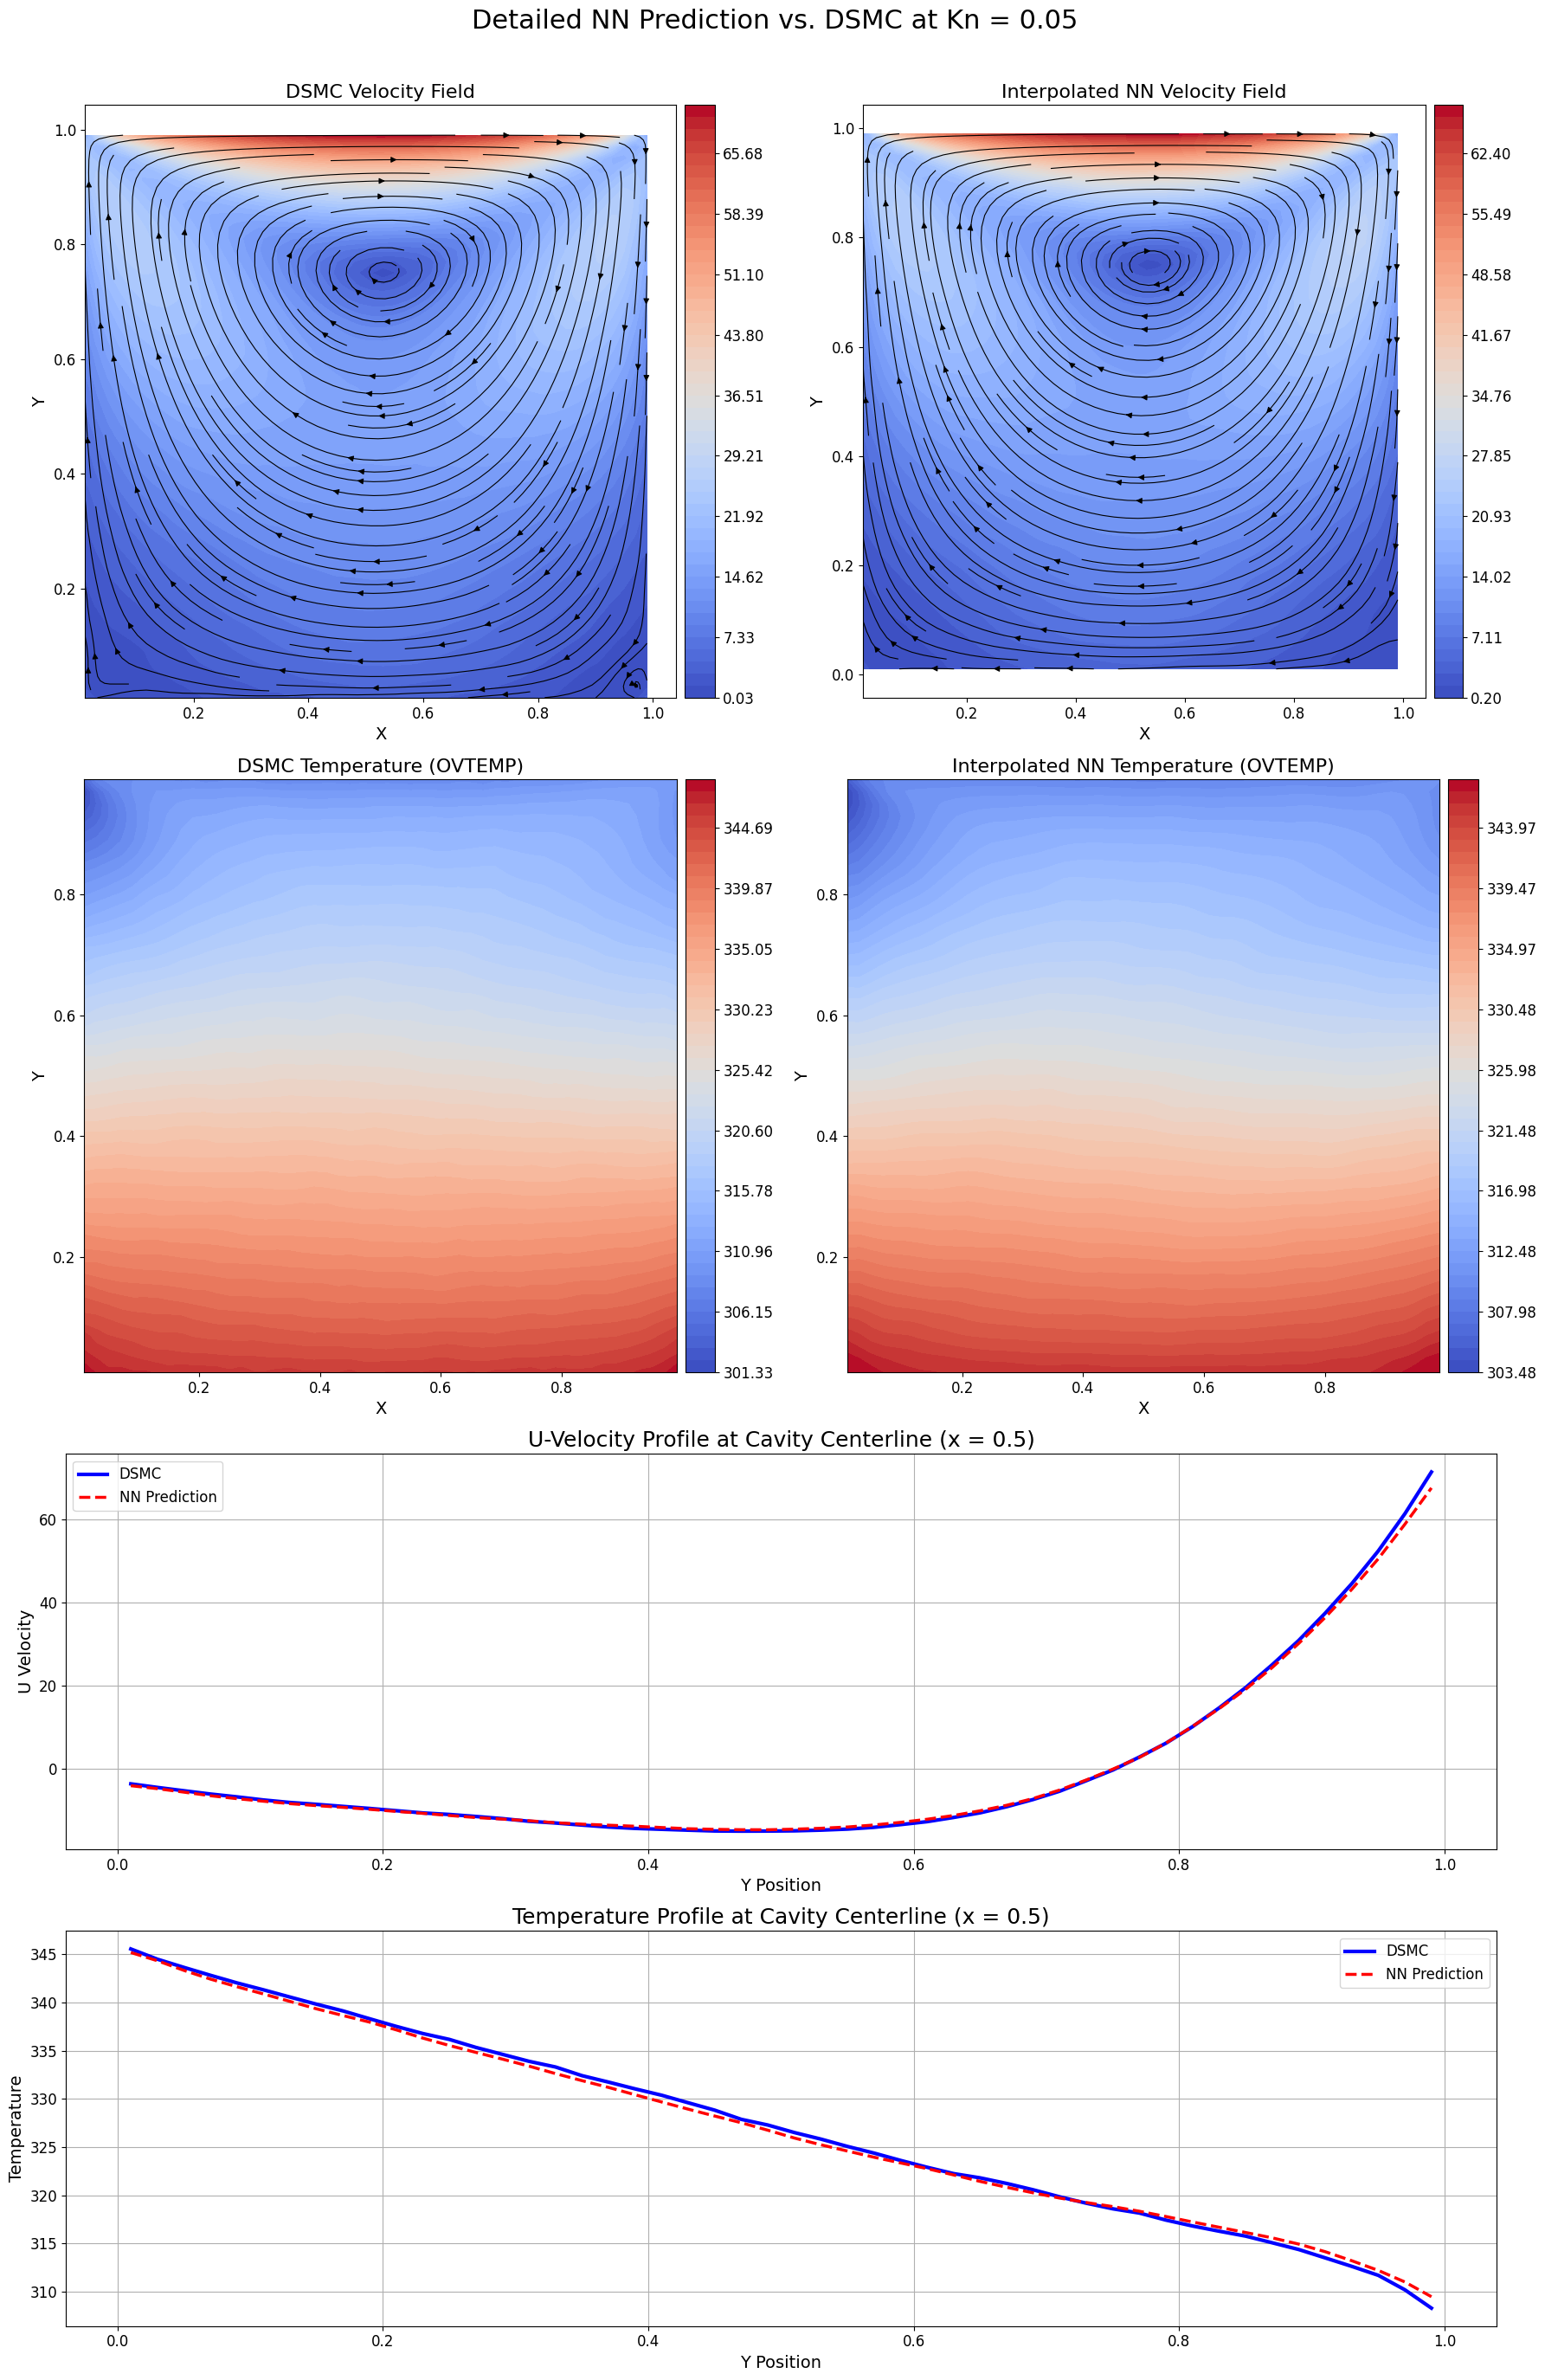

In [10]:
# --- گام ۰: وارد کردن کتابخانه‌ها و تنظیمات اولیه ---
import os
import re
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.regularizers import l2
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import time
import random
from mpl_toolkits.axes_grid1 import make_axes_locatable

# برای اطمینان از نتایج تکرارپذیر
os.environ['PYTHONHASHSEED']=str(42)
tf.random.set_seed(42)
np.random.seed(42)
random.seed(42)

# --- گام ۱: تابع پارسر نهایی برای خواندن فایل‌های Tecplot ---
def parse_tecplot_block_ascii(file_path):
    print(f"Parsing file: {file_path}...")
    try:
        with open(file_path, 'r') as f: content = f.read()
        var_block_match = re.search(r'VARIABLES\s*=\s*(.*?)ZONE', content, re.IGNORECASE | re.DOTALL)
        if not var_block_match: raise ValueError("Could not find VARIABLES block.")
        var_block_str = var_block_match.group(1)
        variables = re.findall(r'"(.*?)"', var_block_str)
        if not variables: raise ValueError("No variables found.")
        zone_header_match = re.search(r'ZONE.*?(I\s*=\s*(\d+)).*?(J\s*=\s*(\d+))', content, re.IGNORECASE | re.DOTALL)
        if not zone_header_match: raise ValueError("Could not find I, J dimensions.")
        i_dim, j_dim = int(zone_header_match.group(2)), int(zone_header_match.group(4))
        num_points = i_dim * j_dim
        metadata = {'I': i_dim, 'J': j_dim, 'variables': variables}
        dt_line_match = re.search(r'DT\s*=\s*\(.*\)', content, re.IGNORECASE)
        if not dt_line_match: raise ValueError("Could not find DT line.")
        data_start_index = dt_line_match.end()
        data_str = content[data_start_index:]
        flat_data = np.fromstring(data_str, sep=' ')
        num_vars = len(variables)
        expected_size = num_vars * num_points
        if flat_data.size < expected_size: raise ValueError(f"Data size mismatch: Expected {expected_size}, Found {flat_data.size}")
        flat_data = flat_data[:expected_size]
        block_data = flat_data.reshape((num_vars, num_points))
        df = pd.DataFrame(block_data.T, columns=variables)
        print(f"Successfully parsed {num_points} points and {num_vars} variables.")
        return df, metadata
    except Exception as e:
        print(f"An error occurred while parsing {file_path}: {e}")
        return pd.DataFrame(), {}

# --- گام ۲: تعریف معماری اثبات‌شده و داده‌ها ---
def create_proven_specialist_model(input_shape, output_shape):
    class FourierFeatures(layers.Layer):
        def __init__(self, output_dims, scale=2.5):
            super(FourierFeatures, self).__init__()
            self.output_dims, self.scale = output_dims, scale
            self.B = self.add_weight(name='B', shape=[2, self.output_dims // 2], initializer=tf.random_normal_initializer(stddev=self.scale), trainable=False)
        def call(self, x):
            x_proj = 2 * np.pi * x @ self.B
            return tf.concat([tf.sin(x_proj), tf.cos(x_proj)], axis=-1)
    L2_LAMBDA, FF_DIMS, DENSE_UNITS = 1e-6, 256, 256
    pos_input = keras.Input(shape=input_shape, name='position_input')
    ff_layer = FourierFeatures(FF_DIMS)(pos_input)
    x = layers.Dense(DENSE_UNITS, activation="swish", kernel_regularizer=l2(L2_LAMBDA))(ff_layer)
    x = layers.Dropout(0.2)(x)
    x = layers.Dense(DENSE_UNITS, activation="swish", kernel_regularizer=l2(L2_LAMBDA))(x)
    x = layers.Dropout(0.2)(x)
    x = layers.Dense(DENSE_UNITS, activation="swish", kernel_regularizer=l2(L2_LAMBDA))(x)
    output_layer = layers.Dense(output_shape, activation="linear")(x)
    model = keras.Model(inputs=pos_input, outputs=output_layer)
    model.compile(optimizer=keras.optimizers.Adam(1e-3), loss="mean_squared_error")
    return model

file_kn_map = {
    'CavityKn10': 10.0, 'CavityKn1': 1.0, 'CavityKn05': 0.5, 'CavityKn01': 0.1,
    'CavityKn005': 0.05, 'CavityKn001': 0.01, 'CavityKn0001': 0.001
}
test_kn_value = 0.05
DATA_DIR = './'

# --- گام ۳: آموزش خانواده مدل‌ها با نرمال‌سازی سراسری ---
print("--- Loading all training data for global scaling ---")
all_training_data_dfs = []
train_kn_values = sorted([kn for kn in file_kn_map.values() if kn != test_kn_value])
for kn_val in train_kn_values:
    basename = [name for name, kn in file_kn_map.items() if kn == kn_val][0]
    possible_paths = [os.path.join(DATA_DIR, basename), os.path.join(DATA_DIR, f"{basename}.dat"), os.path.join(DATA_DIR, f"{basename}.txt")]
    filepath = next((path for path in possible_paths if os.path.exists(path)), None)
    if filepath:
        df, _ = parse_tecplot_block_ascii(filepath)
        if not df.empty:
            df['Kn'] = kn_val
            all_training_data_dfs.append(df)

if not all_training_data_dfs: raise ValueError("No training data could be loaded.")
full_train_df = pd.concat(all_training_data_dfs, ignore_index=True)
input_features, output_features = ['X', 'Y'], [v for v in full_train_df.columns if v not in ['X', 'Y', 'Kn']]
global_scaler_X = MinMaxScaler()
global_scaler_y = StandardScaler()
global_scaler_X.fit(full_train_df[input_features].values)
global_scaler_y.fit(full_train_df[output_features].values)
print("\n--- Global scalers have been successfully fitted ---")

trained_models = {}
for kn_df in all_training_data_dfs:
    kn_val = kn_df['Kn'].iloc[0]
    start_time = time.time()
    print(f"\n{'='*50}\nTraining specialist model for Kn = {kn_val}\n{'='*50}")
    X_data, y_data = kn_df[input_features].values, kn_df[output_features].values
    X_train_loop, X_val_loop, y_train_loop, y_val_loop = train_test_split(X_data, y_data, test_size=0.15, random_state=42)
    X_train_loop_scaled = global_scaler_X.transform(X_train_loop)
    y_train_loop_scaled = global_scaler_y.transform(y_train_loop)
    X_val_loop_scaled = global_scaler_X.transform(X_val_loop)
    y_val_loop_scaled = global_scaler_y.transform(y_val_loop)
    model = create_proven_specialist_model(input_shape=(2,), output_shape=len(output_features))

    # CHANGED: verbose=0 to make training silent
    history = model.fit(
        X_train_loop_scaled, y_train_loop_scaled, epochs=1000, batch_size=256, verbose=0,
        validation_data=(X_val_loop_scaled, y_val_loop_scaled),
        callbacks=[
            keras.callbacks.EarlyStopping(monitor='val_loss', patience=75, restore_best_weights=True),
            keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=30)
        ]
    )

    trained_models[kn_val] = model
    print(f"Finished proper training for Kn = {kn_val} in {time.time() - start_time:.2f} seconds.")
    print(f"Final validation loss for Kn={kn_val}: {history.history['val_loss'][-1]:.6f}")

# --- گام ۴: درون‌یابی برای داده تست ---
print(f"\n{'='*50}\nPerforming interpolation for test case Kn = {test_kn_value}\n{'='*50}")
test_basename = [name for name, kn in file_kn_map.items() if kn == test_kn_value][0]
possible_paths = [os.path.join(DATA_DIR, test_basename), os.path.join(DATA_DIR, f"{test_basename}.dat"), os.path.join(DATA_DIR, f"{test_basename}.txt")]
test_filepath = next((path for path in possible_paths if os.path.exists(path)), None)
if test_filepath is None: raise FileNotFoundError(f"Test file for Kn={test_kn_value} not found.")

test_df, test_metadata = parse_tecplot_block_ascii(test_filepath)
X_test_coords = test_df[['X', 'Y']].values
I, J = test_metadata['I'], test_metadata['J']
kn_upper = min([kn for kn in train_kn_values if kn > test_kn_value])
kn_lower = max([kn for kn in train_kn_values if kn < test_kn_value])
print(f"Found neighbors for interpolation: Kn_lower={kn_lower}, Kn_upper={kn_upper}")
X_test_scaled = global_scaler_X.transform(X_test_coords)
y_pred_lower_scaled = trained_models[kn_lower].predict(X_test_scaled)
y_pred_upper_scaled = trained_models[kn_upper].predict(X_test_scaled)
y_pred_lower = global_scaler_y.inverse_transform(y_pred_lower_scaled)
y_pred_upper = global_scaler_y.inverse_transform(y_pred_upper_scaled)
log_kn_test, log_kn_lower, log_kn_upper = np.log10(test_kn_value), np.log10(kn_lower), np.log10(kn_upper)
weight = (log_kn_test - log_kn_lower) / (log_kn_upper - log_kn_lower)
print(f"Interpolation weight (w) = {weight:.4f}")
y_pred_final = (1 - weight) * y_pred_lower + weight * y_pred_upper
y_pred_df = pd.DataFrame(y_pred_final, columns=output_features)
y_pred_df['X'], y_pred_df['Y'] = test_df['X'].values, test_df['Y'].values

# --- گام ۵: مصورسازی جامع و نهایی ---
def plot_final_analysis(ground_truth_df, df_pred, I, J, kn_value):
    print("\nGenerating final detailed comparison plots...")

    fig = plt.figure(figsize=(18, 28))
    gs = fig.add_gridspec(4, 2, height_ratios=[3, 3, 2, 2])
    fig.suptitle(f'Detailed NN Prediction vs. DSMC at Kn = {kn_value}', fontsize=22)

    X_grid, Y_grid = ground_truth_df['X'].values.reshape(J, I), ground_truth_df['Y'].values.reshape(J, I)

    def draw_contour(ax, X, Y, Z, title, cmap):
        vmin, vmax = np.min(Z), np.max(Z)
        levels = np.linspace(vmin, vmax, 50)
        ax.set_title(title, fontsize=16)
        cf = ax.contourf(X, Y, Z, levels=levels, cmap=cmap, vmin=vmin, vmax=vmax)
        ax.set_aspect('equal', adjustable='box')
        ax.set_xlabel('X', fontsize=14); ax.set_ylabel('Y', fontsize=14)
        ax.tick_params(axis='both', which='major', labelsize=12)
        divider = make_axes_locatable(ax)
        cax = divider.append_axes("right", size="5%", pad=0.1)
        cbar = fig.colorbar(cf, cax=cax)
        cbar.ax.tick_params(labelsize=12)

    # ردیف اول: میدان سرعت
    ax_v_true, ax_v_pred = fig.add_subplot(gs[0, 0]), fig.add_subplot(gs[0, 1])
    Vmag_true = np.sqrt(ground_truth_df['U']**2 + ground_truth_df['V']**2).values.reshape(J, I)
    Vmag_pred = np.sqrt(df_pred['U']**2 + df_pred['V']**2).values.reshape(J, I)
    U_true_grid, V_true_grid = ground_truth_df['U'].values.reshape(J, I), ground_truth_df['V'].values.reshape(J, I)
    U_pred_grid, V_pred_grid = df_pred['U'].values.reshape(J, I), df_pred['V'].values.reshape(J, I)
    draw_contour(ax_v_true, X_grid, Y_grid, Vmag_true, 'DSMC Velocity Field', 'coolwarm')
    ax_v_true.streamplot(X_grid, Y_grid, U_true_grid, V_true_grid, density=1.5, color='black', linewidth=0.8)
    draw_contour(ax_v_pred, X_grid, Y_grid, Vmag_pred, 'Interpolated NN Velocity Field', 'coolwarm')
    ax_v_pred.streamplot(X_grid, Y_grid, U_pred_grid, V_pred_grid, density=1.5, color='black', linewidth=0.8)

    # ردیف دوم: دما
    ax_t_true, ax_t_pred = fig.add_subplot(gs[1, 0]), fig.add_subplot(gs[1, 1])
    Temp_true, Temp_pred = ground_truth_df['OVTEMP'].values.reshape(J, I), df_pred['OVTEMP'].values.reshape(J, I)
    draw_contour(ax_t_true, X_grid, Y_grid, Temp_true, 'DSMC Temperature (OVTEMP)', 'coolwarm')
    draw_contour(ax_t_pred, X_grid, Y_grid, Temp_pred, 'Interpolated NN Temperature (OVTEMP)', 'coolwarm')

    # ردیف سوم و چهارم: پروفایل‌ها
    ax_prof_v = fig.add_subplot(gs[2, :])
    ax_prof_t = fig.add_subplot(gs[3, :])

    y_locations = {'Top': 0.8, 'Middle': 0.5, 'Bottom': 0.2}
    colors = {'Top': 'green', 'Middle': 'purple', 'Bottom': 'orange'}
    centerline_x_val = 0.5
    center_idx = np.abs(X_grid[0, :] - centerline_x_val).argmin()
    y_profile_center = Y_grid[:, center_idx]

    ax_prof_v.set_title(f'U-Velocity Profile at Cavity Centerline (x = {centerline_x_val})', fontsize=18)
    ax_prof_v.plot(y_profile_center, U_true_grid[:, center_idx], 'b-', linewidth=3, label='DSMC')
    ax_prof_v.plot(y_profile_center, U_pred_grid[:, center_idx], 'r--', linewidth=2.5, label='NN Prediction')
    ax_prof_v.set_xlabel('Y Position', fontsize=14); ax_prof_v.set_ylabel('U Velocity', fontsize=14)
    ax_prof_v.tick_params(axis='both', which='major', labelsize=12)
    ax_prof_v.grid(True); ax_prof_v.legend(fontsize=12)

    ax_prof_t.set_title(f'Temperature Profile at Cavity Centerline (x = {centerline_x_val})', fontsize=18)
    ax_prof_t.plot(y_profile_center, Temp_true[:, center_idx], 'b-', linewidth=3, label='DSMC')
    ax_prof_t.plot(y_profile_center, Temp_pred[:, center_idx], 'r--', linewidth=2.5, label='NN Prediction')
    ax_prof_t.set_xlabel('Y Position', fontsize=14); ax_prof_t.set_ylabel('Temperature', fontsize=14)
    ax_prof_t.tick_params(axis='both', which='major', labelsize=12)
    ax_prof_t.grid(True); ax_prof_t.legend(fontsize=12)

    fig.tight_layout(rect=[0, 0, 1, 0.97])
    output_filename = f'final_detailed_analysis_kn_{kn_value}.jpg'
    plt.savefig(output_filename, dpi=300, bbox_inches='tight')
    print(f"\nComprehensive analysis plot saved to '{output_filename}'.")
    plt.show()

# فراخوانی تابع نهایی
plot_final_analysis(test_df, y_pred_df, I, J, test_kn_value)

Parsing file: ./CavityKn01.dat...
Successfully parsed 2500 points and 11 variables.

Data preprocessing for single Kn complete.

Training Model 1/5
Finished training model 1. Final validation loss: 0.000824

Training Model 2/5
Finished training model 2. Final validation loss: 0.000870

Training Model 3/5
Finished training model 3. Final validation loss: 0.000772

Training Model 4/5
Finished training model 4. Final validation loss: 0.000852

Training Model 5/5
Finished training model 5. Final validation loss: 0.000817

Predicting with ensemble and calculating uncertainty...

Generating final UQ analysis plots for Velocity and Temperature...
-> Velocity UQ plot saved to 'uq_analysis_velocity_kn_0.1.jpg'


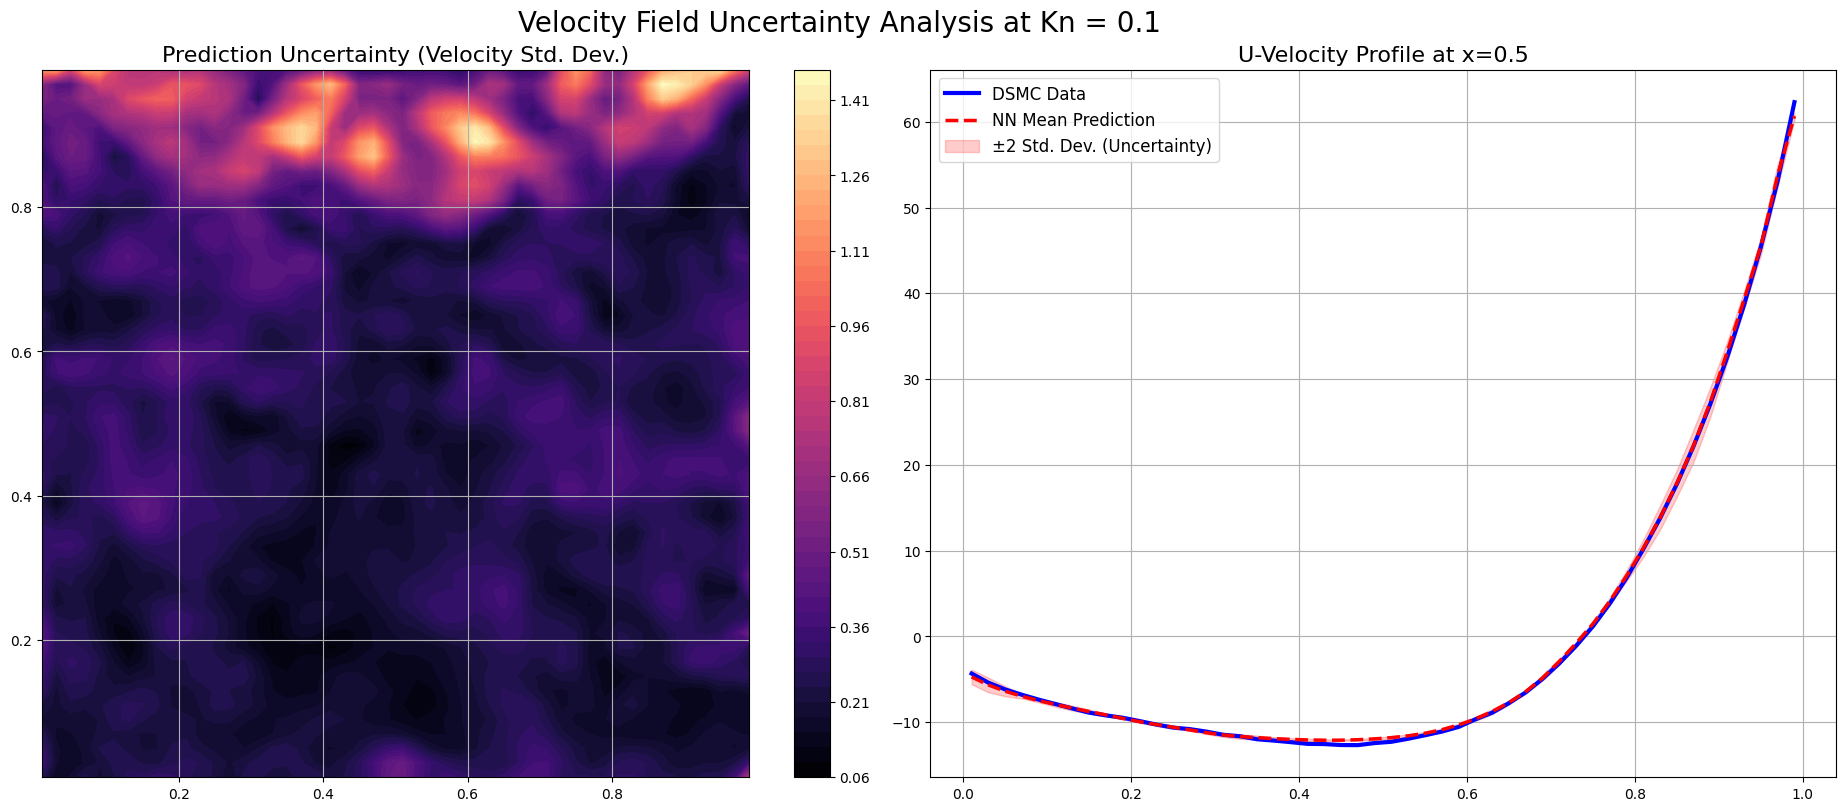

-> Temperature UQ plot saved to 'uq_analysis_temperature_kn_0.1.jpg'


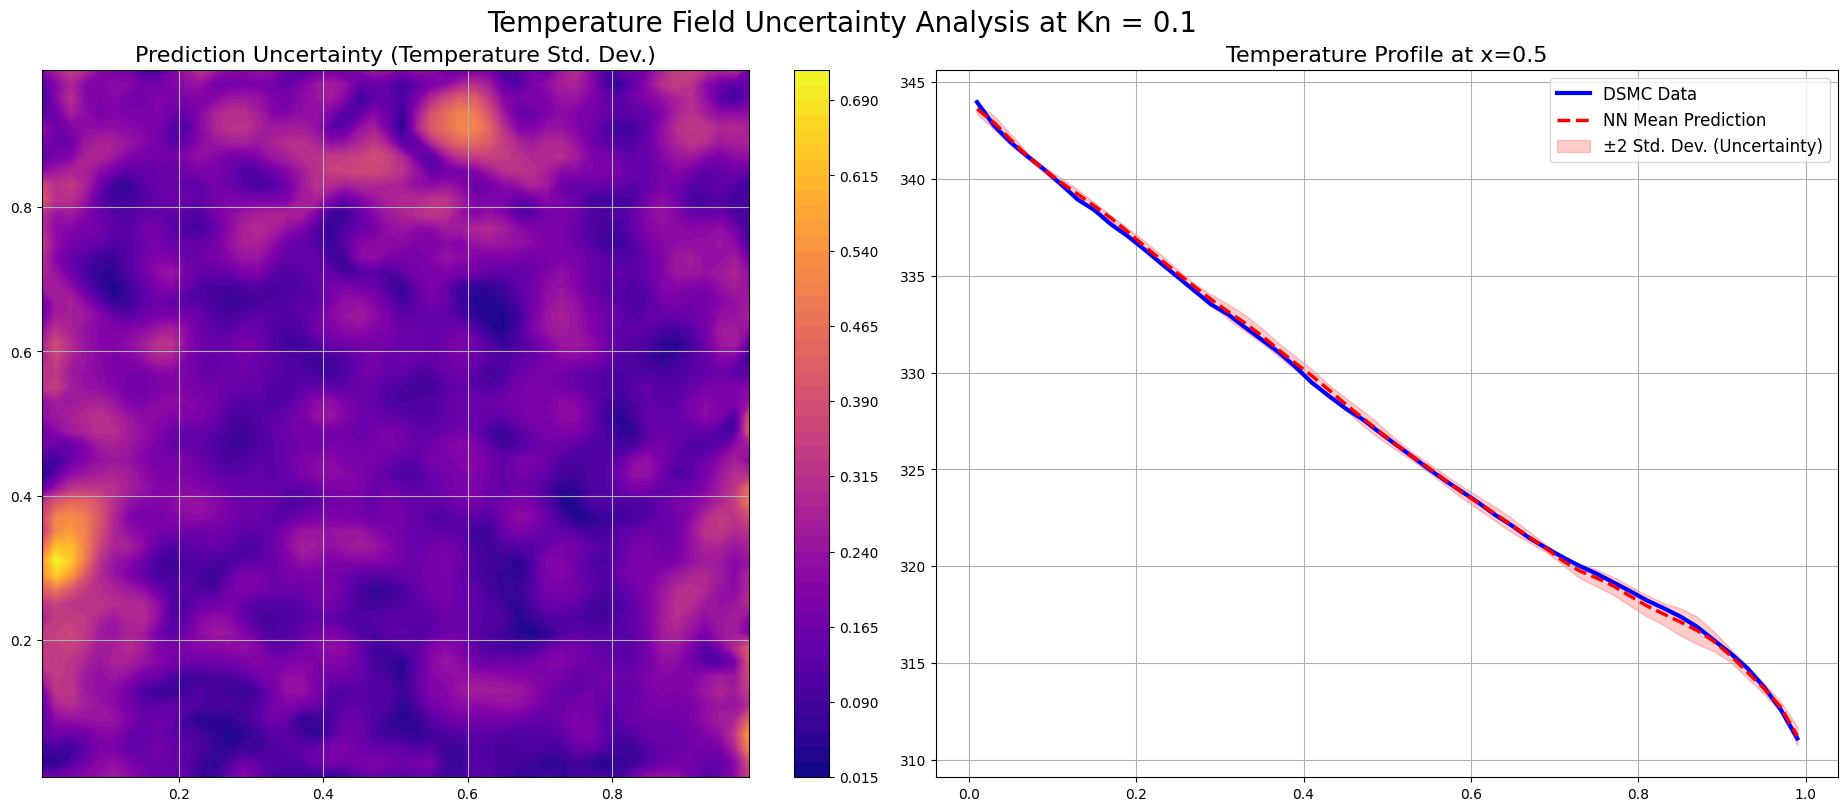

In [12]:
# --- گام ۰: وارد کردن کتابخانه‌ها و تنظیمات اولیه ---
import os
import re
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.regularizers import l2
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import time
import random
from mpl_toolkits.axes_grid1 import make_axes_locatable

# --- گام ۱: تابع پارسر اثبات‌شده ---
def parse_tecplot_block_ascii(file_path):
    # This function is complete and correct from previous steps
    print(f"Parsing file: {file_path}...")
    try:
        with open(file_path, 'r') as f: content = f.read()
        var_block_match = re.search(r'VARIABLES\s*=\s*(.*?)ZONE', content, re.IGNORECASE | re.DOTALL)
        if not var_block_match: raise ValueError("Could not find VARIABLES block.")
        var_block_str = var_block_match.group(1)
        variables = re.findall(r'"(.*?)"', var_block_str)
        if not variables: raise ValueError("No variables found.")
        zone_header_match = re.search(r'ZONE.*?(I\s*=\s*(\d+)).*?(J\s*=\s*(\d+))', content, re.IGNORECASE | re.DOTALL)
        if not zone_header_match: raise ValueError("Could not find I, J dimensions.")
        i_dim, j_dim = int(zone_header_match.group(2)), int(zone_header_match.group(4))
        num_points = i_dim * j_dim
        metadata = {'I': i_dim, 'J': j_dim, 'variables': variables}
        dt_line_match = re.search(r'DT\s*=\s*\(.*\)', content, re.IGNORECASE)
        if not dt_line_match: raise ValueError("Could not find DT line.")
        data_start_index = dt_line_match.end()
        data_str = content[data_start_index:]
        flat_data = np.fromstring(data_str, sep=' ')
        num_vars = len(variables)
        expected_size = num_vars * num_points
        if flat_data.size < expected_size: raise ValueError(f"Data size mismatch: Expected {expected_size}, Found {flat_data.size}")
        flat_data = flat_data[:expected_size]
        block_data = flat_data.reshape((num_vars, num_points))
        df = pd.DataFrame(block_data.T, columns=variables)
        print(f"Successfully parsed {num_points} points and {num_vars} variables.")
        return df, metadata
    except Exception as e:
        print(f"An error occurred while parsing {file_path}: {e}")
        return pd.DataFrame(), {}

# --- گام ۲: تعریف معماری موفق ---
def create_proven_specialist_model(input_shape, output_shape):
    class FourierFeatures(layers.Layer):
        def __init__(self, output_dims, scale=2.5):
            super(FourierFeatures, self).__init__()
            self.output_dims, self.scale = output_dims, scale
            self.B = self.add_weight(name='B', shape=[2, self.output_dims // 2], initializer=tf.random_normal_initializer(stddev=self.scale), trainable=False)
        def call(self, x):
            x_proj = 2 * np.pi * x @ self.B
            return tf.concat([tf.sin(x_proj), tf.cos(x_proj)], axis=-1)
    L2_LAMBDA, FF_DIMS, DENSE_UNITS = 1e-6, 256, 256
    pos_input = keras.Input(shape=input_shape, name='position_input')
    ff_layer = FourierFeatures(FF_DIMS)(pos_input)
    x = layers.Dense(DENSE_UNITS, activation="swish", kernel_regularizer=l2(L2_LAMBDA))(ff_layer)
    x = layers.Dropout(0.2)(x)
    x = layers.Dense(DENSE_UNITS, activation="swish", kernel_regularizer=l2(L2_LAMBDA))(x)
    x = layers.Dropout(0.2)(x)
    x = layers.Dense(DENSE_UNITS, activation="swish", kernel_regularizer=l2(L2_LAMBDA))(x)
    output_layer = layers.Dense(output_shape, activation="sigmoid")(x)
    model = keras.Model(inputs=pos_input, outputs=output_layer)
    model.compile(optimizer=keras.optimizers.Adam(1e-3), loss="mean_squared_error")
    return model

# --- گام ۳: بارگذاری و آموزش گروهی مدل‌ها ---
DATA_DIR = './'
target_filename = 'CavityKn01.dat'
kn_value = 0.1
N_ENSEMBLE = 5 # تعداد مدل‌ها در گروه

# آماده‌سازی داده‌ها
full_path = os.path.join(DATA_DIR, target_filename)
if not os.path.exists(full_path): raise FileNotFoundError(f"Target file not found at {full_path}.")
df, metadata = parse_tecplot_block_ascii(full_path)
if df.empty: raise SystemExit("Data loading failed.")
I, J = metadata['I'], metadata['J']
input_features, output_features = ['X', 'Y'], [v for v in metadata['variables'] if v not in ['X', 'Y']]
X, y = df[input_features].values, df[output_features].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
scaler_X, scaler_y = MinMaxScaler(), MinMaxScaler()
X_train_scaled = scaler_X.fit_transform(X_train)
y_train_scaled = scaler_y.fit_transform(y_train)
print("\nData preprocessing for single Kn complete.")

# آموزش گروهی
ensemble_models = []
for i in range(N_ENSEMBLE):
    print(f"\n{'='*50}\nTraining Model {i+1}/{N_ENSEMBLE}\n{'='*50}")
    tf.random.set_seed(i); np.random.seed(i); random.seed(i)
    model = create_proven_specialist_model(input_shape=(2,), output_shape=len(output_features))
    X_test_scaled, y_test_scaled = scaler_X.transform(X_test), scaler_y.transform(y_test)
    history = model.fit(
        X_train_scaled, y_train_scaled, epochs=1000, batch_size=256, verbose=0,
        validation_data=(X_test_scaled, y_test_scaled),
        callbacks=[keras.callbacks.EarlyStopping(patience=100, restore_best_weights=True)]
    )
    ensemble_models.append(model)
    print(f"Finished training model {i+1}. Final validation loss: {history.history['val_loss'][-1]:.6f}")

# --- گام ۴: پیش‌بینی گروهی و تحلیل عدم قطعیت ---
print("\nPredicting with ensemble and calculating uncertainty...")
all_predictions_scaled = []
X_full_domain_scaled = scaler_X.transform(df[input_features].values)
for model in ensemble_models:
    pred_scaled = model.predict(X_full_domain_scaled, verbose=0)
    all_predictions_scaled.append(pred_scaled)

predictions_stack_scaled = np.stack(all_predictions_scaled)
mean_pred_scaled = np.mean(predictions_stack_scaled, axis=0)
std_pred_scaled = np.std(predictions_stack_scaled, axis=0)
mean_pred = scaler_y.inverse_transform(mean_pred_scaled)
std_pred = std_pred_scaled * (scaler_y.data_max_ - scaler_y.data_min_)
mean_pred_df = pd.DataFrame(mean_pred, columns=output_features)
std_pred_df = pd.DataFrame(std_pred, columns=output_features)

# --- گام ۵: مصورسازی نهایی ---
def plot_final_uq_analysis(ground_truth_df, mean_pred_df, std_pred_df, I, J, kn_value, n_ensemble):
    print("\nGenerating final UQ analysis plots for Velocity and Temperature...")

    X_grid, Y_grid = ground_truth_df['X'].values.reshape(J, I), ground_truth_df['Y'].values.reshape(J, I)

    # --- مصورسازی برای سرعت ---
    fig_v, axes_v = plt.subplots(1, 2, figsize=(20, 8), constrained_layout=True)
    fig_v.suptitle(f'Velocity Field Uncertainty Analysis at Kn = {kn_value}', fontsize=20)

    Vmag_std_pred = np.sqrt(std_pred_df['U']**2 + std_pred_df['V']**2).values.reshape(J, I)
    ax_v1 = axes_v[0]
    ax_v1.set_title('Prediction Uncertainty (Velocity Std. Dev.)', fontsize=16)
    cf_std_v = ax_v1.contourf(X_grid, Y_grid, Vmag_std_pred, levels=50, cmap='magma')
    fig_v.colorbar(cf_std_v, ax=ax_v1)

    ax_v2 = axes_v[1]
    center_idx = np.abs(X_grid[0, :] - 0.5).argmin()
    y_profile, u_profile_true = Y_grid[:, center_idx], ground_truth_df['U'].values.reshape(J, I)[:, center_idx]
    u_profile_mean, u_profile_std = mean_pred_df['U'].values.reshape(J, I)[:, center_idx], std_pred_df['U'].values.reshape(J, I)[:, center_idx]
    ax_v2.set_title('U-Velocity Profile at x=0.5', fontsize=16)
    ax_v2.plot(y_profile, u_profile_true, 'b-', linewidth=3, label='DSMC Data')
    ax_v2.plot(y_profile, u_profile_mean, 'r--', linewidth=2.5, label='NN Mean Prediction')
    ax_v2.fill_between(y_profile, u_profile_mean - 2*u_profile_std, u_profile_mean + 2*u_profile_std, color='red', alpha=0.2, label='±2 Std. Dev. (Uncertainty)')
    ax_v2.legend(fontsize=12)

    for ax in [ax_v1, ax_v2]: ax.grid(True)
    ax_v1.set_aspect('equal', adjustable='box')

    output_filename_v = f'uq_analysis_velocity_kn_{kn_value}.jpg'
    fig_v.savefig(output_filename_v, dpi=300, bbox_inches='tight')
    print(f"-> Velocity UQ plot saved to '{output_filename_v}'")
    plt.show()

    # --- مصورسازی برای دما ---
    fig_t, axes_t = plt.subplots(1, 2, figsize=(20, 8), constrained_layout=True)
    fig_t.suptitle(f'Temperature Field Uncertainty Analysis at Kn = {kn_value}', fontsize=20)

    Temp_std_pred = std_pred_df['OVTEMP'].values.reshape(J, I)
    ax_t1 = axes_t[0]
    ax_t1.set_title('Prediction Uncertainty (Temperature Std. Dev.)', fontsize=16)
    cf_std_t = ax_t1.contourf(X_grid, Y_grid, Temp_std_pred, levels=50, cmap='plasma')
    fig_t.colorbar(cf_std_t, ax=ax_t1)

    ax_t2 = axes_t[1]
    temp_profile_true = ground_truth_df['OVTEMP'].values.reshape(J, I)[:, center_idx]
    temp_profile_mean = mean_pred_df['OVTEMP'].values.reshape(J, I)[:, center_idx]
    temp_profile_std = std_pred_df['OVTEMP'].values.reshape(J, I)[:, center_idx]
    ax_t2.set_title('Temperature Profile at x=0.5', fontsize=16)
    ax_t2.plot(y_profile, temp_profile_true, 'b-', linewidth=3, label='DSMC Data')
    ax_t2.plot(y_profile, temp_profile_mean, 'r--', linewidth=2.5, label='NN Mean Prediction')
    ax_t2.fill_between(y_profile, temp_profile_mean - 2*temp_profile_std, temp_profile_mean + 2*temp_profile_std, color='red', alpha=0.2, label='±2 Std. Dev. (Uncertainty)')
    ax_t2.legend(fontsize=12)

    for ax in [ax_t1, ax_t2]: ax.grid(True)
    ax_t1.set_aspect('equal', adjustable='box')

    output_filename_t = f'uq_analysis_temperature_kn_{kn_value}.jpg'
    fig_t.savefig(output_filename_t, dpi=300, bbox_inches='tight')
    print(f"-> Temperature UQ plot saved to '{output_filename_t}'")
    plt.show()

# فراخوانی تابع نهایی
plot_final_uq_analysis(df, mean_pred_df, std_pred_df, I, J, kn_value, N_ENSEMBLE)

In [13]:
!pip install tensorflow-probability

--- Loading all training data for global scaling ---
Parsing file: ./CavityKn0001.dat...
Successfully parsed 2500 points and 11 variables.
Parsing file: ./CavityKn001.dat...
Successfully parsed 2500 points and 11 variables.
Parsing file: ./CavityKn005.dat...
Successfully parsed 2500 points and 11 variables.
Parsing file: ./CavityKn01.dat...
Successfully parsed 2500 points and 11 variables.
Parsing file: ./CavityKn1.dat...
Successfully parsed 2500 points and 11 variables.
Parsing file: ./CavityKn10.dat...
Successfully parsed 2500 points and 11 variables.

--- Global scalers have been successfully fitted ---

Training specialist model for Kn = 0.001
Starting proper training with global scalers...
Finished proper training for Kn = 0.001 in 79.22 seconds.

Training specialist model for Kn = 0.01
Starting proper training with global scalers...
Finished proper training for Kn = 0.01 in 124.89 seconds.

Training specialist model for Kn = 0.05
Starting proper training with global scalers...
Fi

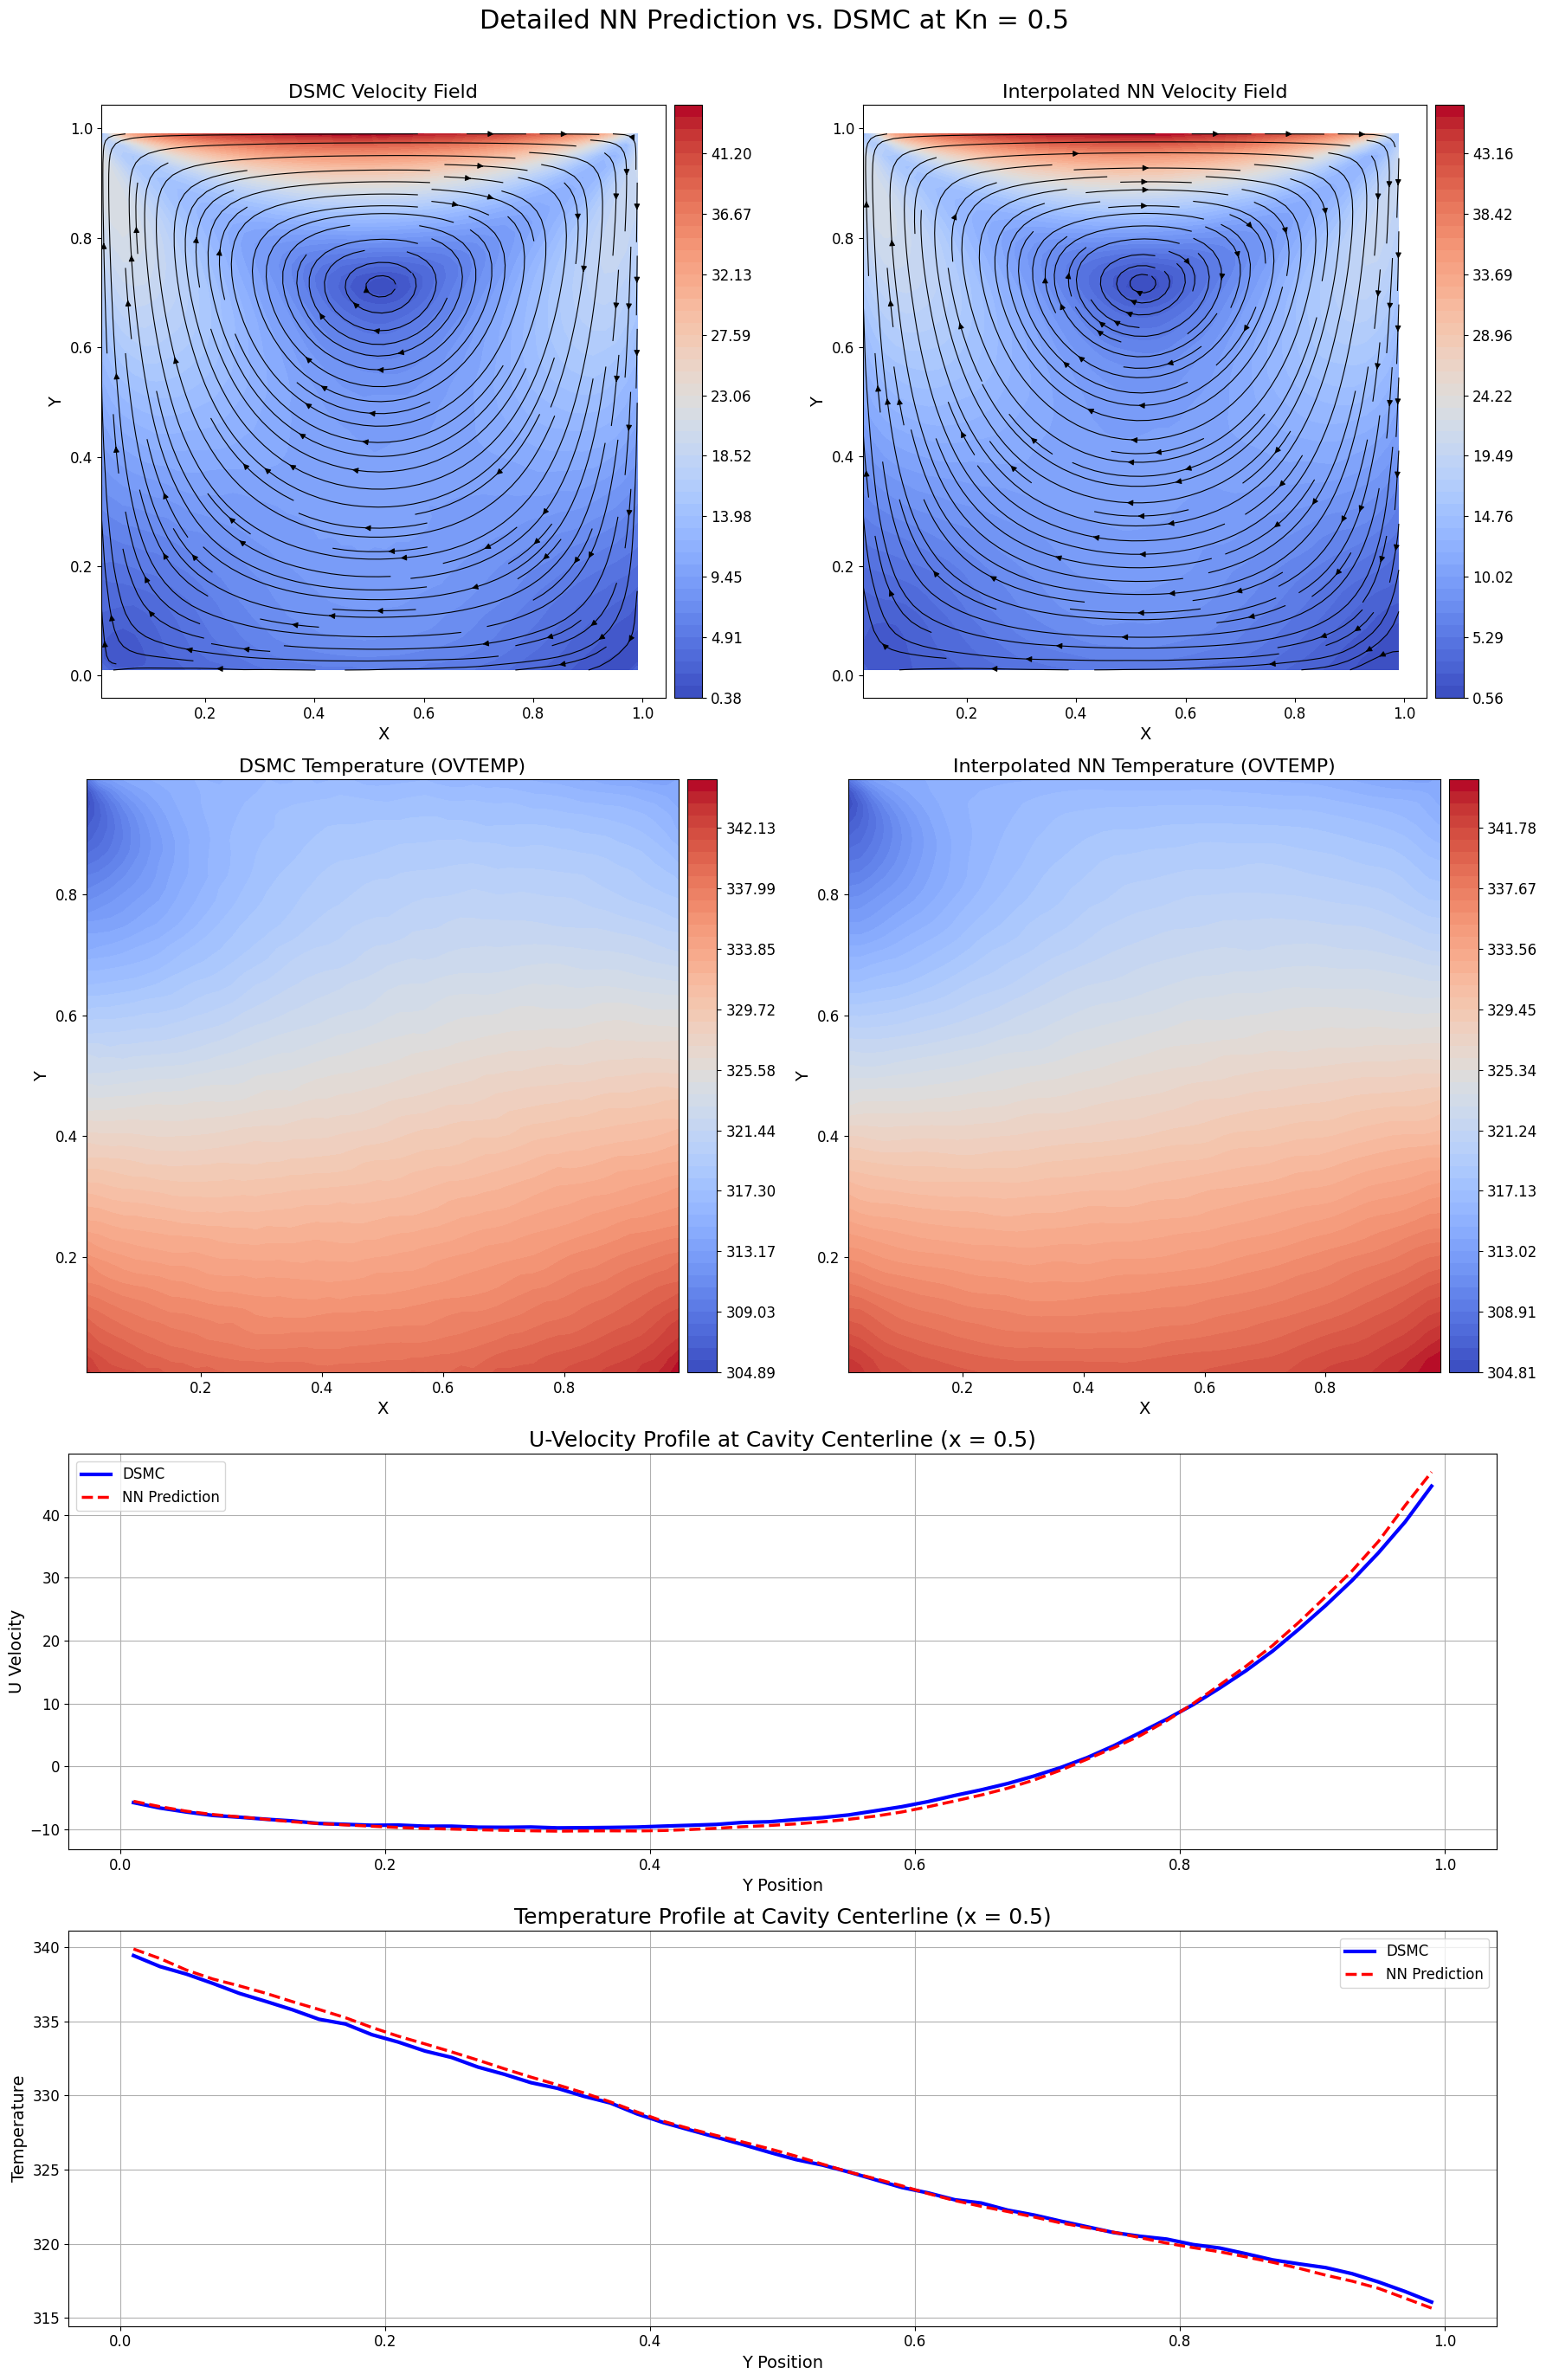

In [20]:
# --- گام ۰: وارد کردن کتابخانه‌ها و تنظیمات اولیه ---
import os
import re
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.regularizers import l2
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import time
import random
from mpl_toolkits.axes_grid1 import make_axes_locatable

# برای اطمینان از نتایج تکرارپذیر
os.environ['PYTHONHASHSEED']=str(42)
tf.random.set_seed(42)
np.random.seed(42)
random.seed(42)

# --- گام ۱: تابع پارسر نهایی برای خواندن فایل‌های Tecplot ---
def parse_tecplot_block_ascii(file_path):
    print(f"Parsing file: {file_path}...")
    try:
        with open(file_path, 'r') as f: content = f.read()
        var_block_match = re.search(r'VARIABLES\s*=\s*(.*?)ZONE', content, re.IGNORECASE | re.DOTALL)
        if not var_block_match: raise ValueError("Could not find VARIABLES block.")
        var_block_str = var_block_match.group(1)
        variables = re.findall(r'"(.*?)"', var_block_str)
        if not variables: raise ValueError("No variables found.")
        zone_header_match = re.search(r'ZONE.*?(I\s*=\s*(\d+)).*?(J\s*=\s*(\d+))', content, re.IGNORECASE | re.DOTALL)
        if not zone_header_match: raise ValueError("Could not find I, J dimensions.")
        i_dim, j_dim = int(zone_header_match.group(2)), int(zone_header_match.group(4))
        num_points = i_dim * j_dim
        metadata = {'I': i_dim, 'J': j_dim, 'variables': variables}
        dt_line_match = re.search(r'DT\s*=\s*\(.*\)', content, re.IGNORECASE)
        if not dt_line_match: raise ValueError("Could not find DT line.")
        data_start_index = dt_line_match.end()
        data_str = content[data_start_index:]
        flat_data = np.fromstring(data_str, sep=' ')
        num_vars = len(variables)
        expected_size = num_vars * num_points
        if flat_data.size < expected_size: raise ValueError(f"Data size mismatch: Expected {expected_size}, Found {flat_data.size}")
        flat_data = flat_data[:expected_size]
        block_data = flat_data.reshape((num_vars, num_points))
        df = pd.DataFrame(block_data.T, columns=variables)
        print(f"Successfully parsed {num_points} points and {num_vars} variables.")
        return df, metadata
    except Exception as e:
        print(f"An error occurred while parsing {file_path}: {e}")
        return pd.DataFrame(), {}

# --- گام ۲: تعریف معماری اثبات‌شده و داده‌ها ---
def create_proven_specialist_model(input_shape, output_shape):
    class FourierFeatures(layers.Layer):
        def __init__(self, output_dims, scale=2.5):
            super(FourierFeatures, self).__init__()
            self.output_dims, self.scale = output_dims, scale
            self.B = self.add_weight(name='B', shape=[2, self.output_dims // 2], initializer=tf.random_normal_initializer(stddev=self.scale), trainable=False)
        def call(self, x):
            x_proj = 2 * np.pi * x @ self.B
            return tf.concat([tf.sin(x_proj), tf.cos(x_proj)], axis=-1)
    L2_LAMBDA, FF_DIMS, DENSE_UNITS = 1e-6, 256, 256
    pos_input = keras.Input(shape=input_shape, name='position_input')
    ff_layer = FourierFeatures(FF_DIMS)(pos_input)
    x = layers.Dense(DENSE_UNITS, activation="swish", kernel_regularizer=l2(L2_LAMBDA))(ff_layer)
    x = layers.Dropout(0.2)(x)
    x = layers.Dense(DENSE_UNITS, activation="swish", kernel_regularizer=l2(L2_LAMBDA))(x)
    x = layers.Dropout(0.2)(x)
    x = layers.Dense(DENSE_UNITS, activation="swish", kernel_regularizer=l2(L2_LAMBDA))(x)
    output_layer = layers.Dense(output_shape, activation="linear")(x)
    model = keras.Model(inputs=pos_input, outputs=output_layer)
    model.compile(optimizer=keras.optimizers.Adam(1e-3), loss="mean_squared_error")
    return model

file_kn_map = {
    'CavityKn10': 10.0, 'CavityKn1': 1.0, 'CavityKn05': 0.5, 'CavityKn01': 0.1,
    'CavityKn005': 0.05, 'CavityKn001': 0.01, 'CavityKn0001': 0.001
}
test_kn_value = 0.5
DATA_DIR = './'

# --- گام ۳: آموزش خانواده مدل‌ها با نرمال‌سازی سراسری ---
print("--- Loading all training data for global scaling ---")
all_training_data_dfs = []
train_kn_values = sorted([kn for kn in file_kn_map.values() if kn != test_kn_value])
for kn_val in train_kn_values:
    basename = [name for name, kn in file_kn_map.items() if kn == kn_val][0]
    possible_paths = [os.path.join(DATA_DIR, basename), os.path.join(DATA_DIR, f"{basename}.dat"), os.path.join(DATA_DIR, f"{basename}.txt")]
    filepath = next((path for path in possible_paths if os.path.exists(path)), None)
    if filepath:
        df, _ = parse_tecplot_block_ascii(filepath)
        if not df.empty:
            df['Kn'] = kn_val
            all_training_data_dfs.append(df)

if not all_training_data_dfs: raise ValueError("No training data could be loaded.")
full_train_df = pd.concat(all_training_data_dfs, ignore_index=True)
input_features, output_features = ['X', 'Y'], [v for v in full_train_df.columns if v not in ['X', 'Y', 'Kn']]
global_scaler_X = MinMaxScaler()
global_scaler_y = StandardScaler()
global_scaler_X.fit(full_train_df[input_features].values)
global_scaler_y.fit(full_train_df[output_features].values)
print("\n--- Global scalers have been successfully fitted ---")

trained_models = {}
for kn_df in all_training_data_dfs:
    kn_val = kn_df['Kn'].iloc[0]
    start_time = time.time()
    print(f"\n{'='*50}\nTraining specialist model for Kn = {kn_val}\n{'='*50}")
    X_data, y_data = kn_df[input_features].values, kn_df[output_features].values
    X_train_loop, X_val_loop, y_train_loop, y_val_loop = train_test_split(X_data, y_data, test_size=0.15, random_state=42)
    X_train_loop_scaled = global_scaler_X.transform(X_train_loop)
    y_train_loop_scaled = global_scaler_y.transform(y_train_loop)
    X_val_loop_scaled = global_scaler_X.transform(X_val_loop)
    y_val_loop_scaled = global_scaler_y.transform(y_val_loop)
    model = create_proven_specialist_model(input_shape=(2,), output_shape=len(output_features))
    print("Starting proper training with global scalers...")

    # CHANGED: verbose=0 to make training silent
    history = model.fit(
        X_train_loop_scaled, y_train_loop_scaled, epochs=1000, batch_size=256, verbose=0,
        validation_data=(X_val_loop_scaled, y_val_loop_scaled),
        callbacks=[
            keras.callbacks.EarlyStopping(monitor='val_loss', patience=75, restore_best_weights=True),
            keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=30)
        ]
    )

    trained_models[kn_val] = model
    print(f"Finished proper training for Kn = {kn_val} in {time.time() - start_time:.2f} seconds.")

# --- گام ۴: درون‌یابی برای داده تست ---
print(f"\n{'='*50}\nPerforming interpolation for test case Kn = {test_kn_value}\n{'='*50}")
test_basename = [name for name, kn in file_kn_map.items() if kn == test_kn_value][0]
possible_paths = [os.path.join(DATA_DIR, test_basename), os.path.join(DATA_DIR, f"{test_basename}.dat"), os.path.join(DATA_DIR, f"{test_basename}.txt")]
test_filepath = next((path for path in possible_paths if os.path.exists(path)), None)
if test_filepath is None: raise FileNotFoundError(f"Test file for Kn={test_kn_value} not found.")

test_df, test_metadata = parse_tecplot_block_ascii(test_filepath)
X_test_coords = test_df[['X', 'Y']].values
I, J = test_metadata['I'], test_metadata['J']
kn_upper = min([kn for kn in train_kn_values if kn > test_kn_value])
kn_lower = max([kn for kn in train_kn_values if kn < test_kn_value])
print(f"Found neighbors for interpolation: Kn_lower={kn_lower}, Kn_upper={kn_upper}")
X_test_scaled = global_scaler_X.transform(X_test_coords)
y_pred_lower_scaled = trained_models[kn_lower].predict(X_test_scaled, verbose=0)
y_pred_upper_scaled = trained_models[kn_upper].predict(X_test_scaled, verbose=0)
y_pred_lower = global_scaler_y.inverse_transform(y_pred_lower_scaled)
y_pred_upper = global_scaler_y.inverse_transform(y_pred_upper_scaled)
log_kn_test, log_kn_lower, log_kn_upper = np.log10(test_kn_value), np.log10(kn_lower), np.log10(kn_upper)
weight = (log_kn_test - log_kn_lower) / (log_kn_upper - log_kn_lower)
print(f"Interpolation weight (w) = {weight:.4f}")
y_pred_final = (1 - weight) * y_pred_lower + weight * y_pred_upper
y_pred_df = pd.DataFrame(y_pred_final, columns=output_features)
y_pred_df['X'], y_pred_df['Y'] = test_df['X'].values, test_df['Y'].values

# --- گام ۵: مصورسازی جامع و نهایی ---
def plot_final_analysis(ground_truth_df, df_pred, I, J, kn_value):
    print("\nGenerating final detailed comparison plots...")

    fig = plt.figure(figsize=(18, 28))
    gs = fig.add_gridspec(4, 2, height_ratios=[3, 3, 2, 2])
    fig.suptitle(f'Detailed NN Prediction vs. DSMC at Kn = {kn_value}', fontsize=22)

    X_grid, Y_grid = ground_truth_df['X'].values.reshape(J, I), ground_truth_df['Y'].values.reshape(J, I)

    def draw_contour(ax, X, Y, Z, title, cmap):
        vmin, vmax = np.min(Z), np.max(Z)
        levels = np.linspace(vmin, vmax, 50)
        ax.set_title(title, fontsize=16)
        cf = ax.contourf(X, Y, Z, levels=levels, cmap=cmap, vmin=vmin, vmax=vmax)
        ax.set_aspect('equal', adjustable='box')
        ax.set_xlabel('X', fontsize=14); ax.set_ylabel('Y', fontsize=14)
        ax.tick_params(axis='both', which='major', labelsize=12)
        divider = make_axes_locatable(ax)
        cax = divider.append_axes("right", size="5%", pad=0.1)
        cbar = fig.colorbar(cf, cax=cax)
        cbar.ax.tick_params(labelsize=12)

    # Velocity Field
    ax_v_true, ax_v_pred = fig.add_subplot(gs[0, 0]), fig.add_subplot(gs[0, 1])
    Vmag_true = np.sqrt(ground_truth_df['U']**2 + ground_truth_df['V']**2).values.reshape(J, I)
    Vmag_pred = np.sqrt(df_pred['U']**2 + df_pred['V']**2).values.reshape(J, I)
    U_true_grid, V_true_grid = ground_truth_df['U'].values.reshape(J, I), ground_truth_df['V'].values.reshape(J, I)
    U_pred_grid, V_pred_grid = df_pred['U'].values.reshape(J, I), df_pred['V'].values.reshape(J, I)
    draw_contour(ax_v_true, X_grid, Y_grid, Vmag_true, 'DSMC Velocity Field', 'coolwarm')
    ax_v_true.streamplot(X_grid, Y_grid, U_true_grid, V_true_grid, density=1.5, color='black', linewidth=0.8)
    draw_contour(ax_v_pred, X_grid, Y_grid, Vmag_pred, 'Interpolated NN Velocity Field', 'coolwarm')
    ax_v_pred.streamplot(X_grid, Y_grid, U_pred_grid, V_pred_grid, density=1.5, color='black', linewidth=0.8)

    # Temperature Field
    ax_t_true, ax_t_pred = fig.add_subplot(gs[1, 0]), fig.add_subplot(gs[1, 1])
    Temp_true, Temp_pred = ground_truth_df['OVTEMP'].values.reshape(J, I), df_pred['OVTEMP'].values.reshape(J, I)
    draw_contour(ax_t_true, X_grid, Y_grid, Temp_true, 'DSMC Temperature (OVTEMP)', 'coolwarm')
    draw_contour(ax_t_pred, X_grid, Y_grid, Temp_pred, 'Interpolated NN Temperature (OVTEMP)', 'coolwarm')

    # Line Profiles
    ax_prof_v = fig.add_subplot(gs[2, :])
    ax_prof_t = fig.add_subplot(gs[3, :])

    centerline_x_val = 0.5
    center_idx = np.abs(X_grid[0, :] - centerline_x_val).argmin()
    y_profile_center = Y_grid[:, center_idx]

    ax_prof_v.set_title(f'U-Velocity Profile at Cavity Centerline (x = {centerline_x_val})', fontsize=18)
    ax_prof_v.plot(y_profile_center, U_true_grid[:, center_idx], 'b-', linewidth=3, label='DSMC')
    ax_prof_v.plot(y_profile_center, U_pred_grid[:, center_idx], 'r--', linewidth=2.5, label='NN Prediction')
    ax_prof_v.set_xlabel('Y Position', fontsize=14); ax_prof_v.set_ylabel('U Velocity', fontsize=14)
    ax_prof_v.tick_params(axis='both', which='major', labelsize=12); ax_prof_v.grid(True); ax_prof_v.legend(fontsize=12)

    ax_prof_t.set_title(f'Temperature Profile at Cavity Centerline (x = {centerline_x_val})', fontsize=18)
    ax_prof_t.plot(y_profile_center, Temp_true[:, center_idx], 'b-', linewidth=3, label='DSMC')
    ax_prof_t.plot(y_profile_center, Temp_pred[:, center_idx], 'r--', linewidth=2.5, label='NN Prediction')
    ax_prof_t.set_xlabel('Y Position', fontsize=14); ax_prof_t.set_ylabel('Temperature', fontsize=14)
    ax_prof_t.tick_params(axis='both', which='major', labelsize=12); ax_prof_t.grid(True); ax_prof_t.legend(fontsize=12)

    fig.tight_layout(rect=[0, 0, 1, 0.97])
    output_filename = f'final_detailed_analysis_kn_{kn_value}.jpg'
    plt.savefig(output_filename, dpi=300, bbox_inches='tight')
    print(f"\nComprehensive analysis plot saved to '{output_filename}'.")
    plt.show()

# فراخوانی تابع نهایی
plot_final_analysis(test_df, y_pred_df, I, J, test_kn_value)

--- Loading all training data for global scaling ---
Parsing file: ./CavityKn0001.dat...
Successfully parsed 2500 points and 11 variables.
Parsing file: ./CavityKn001.dat...
Successfully parsed 2500 points and 11 variables.
Parsing file: ./CavityKn01.dat...
Successfully parsed 2500 points and 11 variables.
Parsing file: ./CavityKn05.dat...
Successfully parsed 2500 points and 11 variables.
Parsing file: ./CavityKn1.dat...
Successfully parsed 2500 points and 11 variables.
Parsing file: ./CavityKn10.dat...
Successfully parsed 2500 points and 11 variables.

--- Global scalers have been successfully fitted ---

Training specialist model for Kn = 0.001
Finished proper training for Kn = 0.001 in 83.41 seconds.

Training specialist model for Kn = 0.01
Finished proper training for Kn = 0.01 in 128.51 seconds.

Training specialist model for Kn = 0.1
Finished proper training for Kn = 0.1 in 122.44 seconds.

Training specialist model for Kn = 0.5
Finished proper training for Kn = 0.5 in 165.61 sec

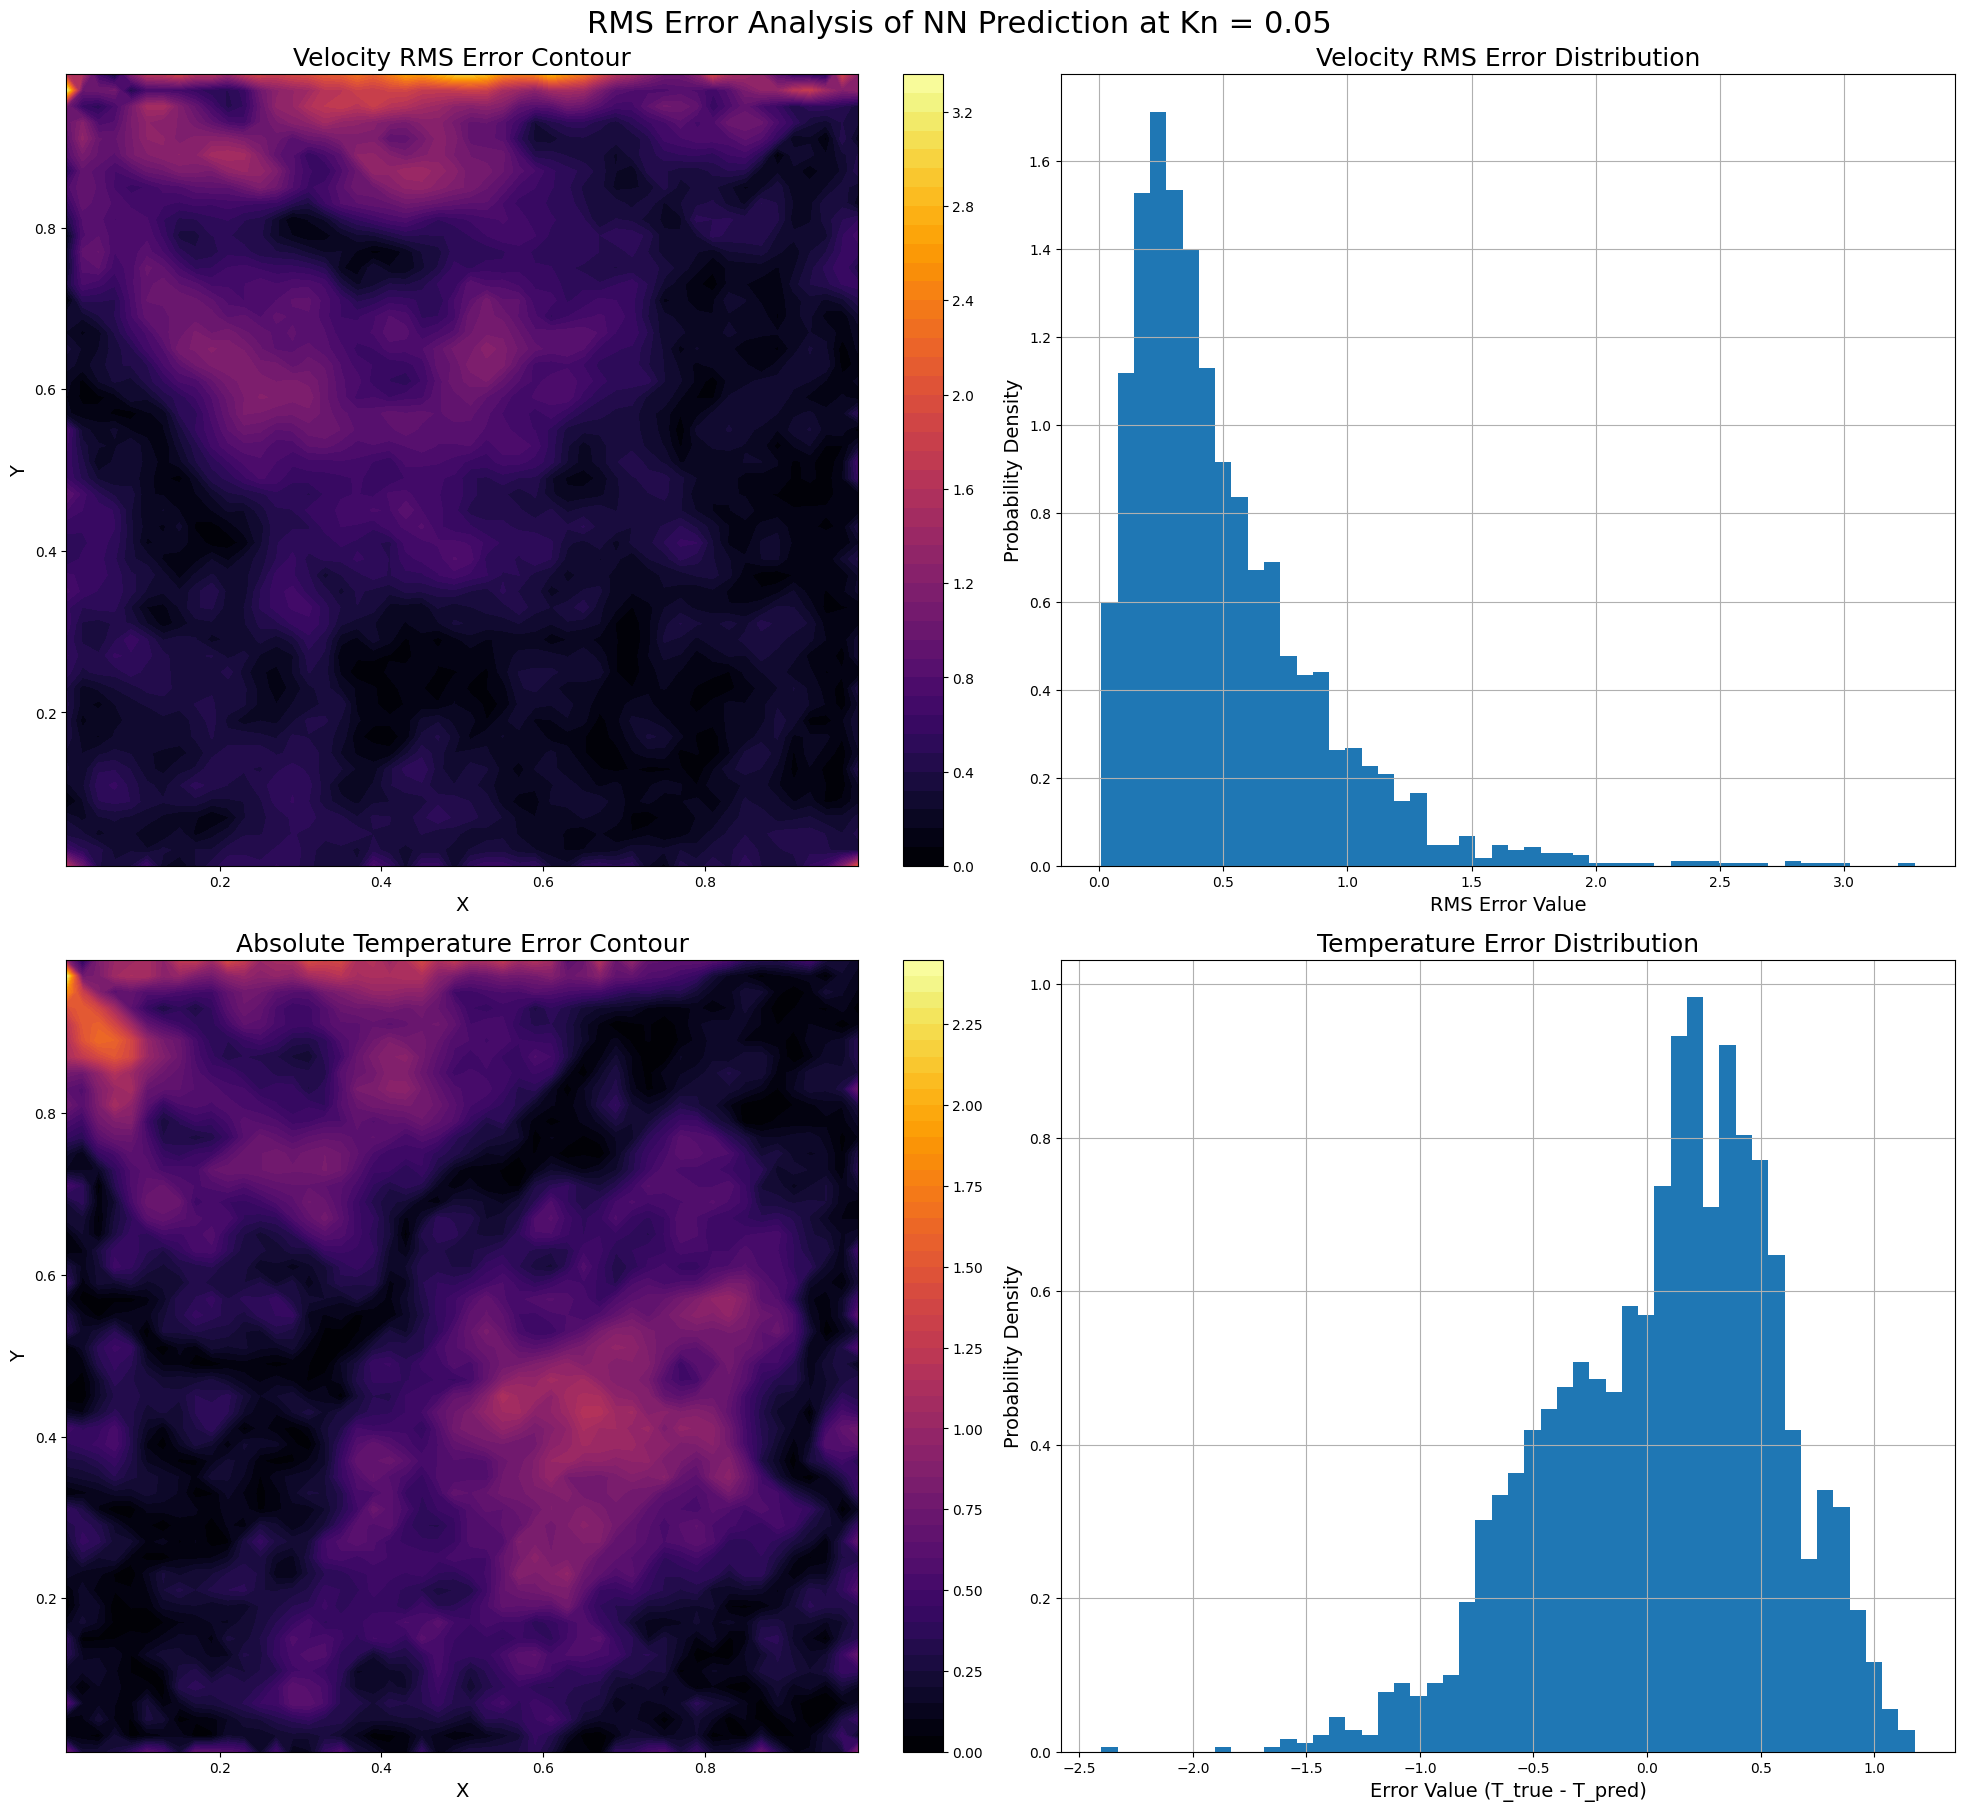

In [21]:
# --- گام ۰: وارد کردن کتابخانه‌ها و تنظیمات اولیه ---
import os
import re
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.regularizers import l2
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import time
import random
from mpl_toolkits.axes_grid1 import make_axes_locatable

# برای اطمینان از نتایج تکرارپذیر
os.environ['PYTHONHASHSEED']=str(42)
tf.random.set_seed(42)
np.random.seed(42)
random.seed(42)

# --- گام ۱: تابع پارسر نهایی برای خواندن فایل‌های Tecplot ---
def parse_tecplot_block_ascii(file_path):
    print(f"Parsing file: {file_path}...")
    try:
        with open(file_path, 'r') as f: content = f.read()
        var_block_match = re.search(r'VARIABLES\s*=\s*(.*?)ZONE', content, re.IGNORECASE | re.DOTALL)
        if not var_block_match: raise ValueError("Could not find VARIABLES block.")
        var_block_str = var_block_match.group(1)
        variables = re.findall(r'"(.*?)"', var_block_str)
        if not variables: raise ValueError("No variables found.")
        zone_header_match = re.search(r'ZONE.*?(I\s*=\s*(\d+)).*?(J\s*=\s*(\d+))', content, re.IGNORECASE | re.DOTALL)
        if not zone_header_match: raise ValueError("Could not find I, J dimensions.")
        i_dim, j_dim = int(zone_header_match.group(2)), int(zone_header_match.group(4))
        num_points = i_dim * j_dim
        metadata = {'I': i_dim, 'J': j_dim, 'variables': variables}
        dt_line_match = re.search(r'DT\s*=\s*\(.*\)', content, re.IGNORECASE)
        if not dt_line_match: raise ValueError("Could not find DT line.")
        data_start_index = dt_line_match.end()
        data_str = content[data_start_index:]
        flat_data = np.fromstring(data_str, sep=' ')
        num_vars = len(variables)
        expected_size = num_vars * num_points
        if flat_data.size < expected_size: raise ValueError(f"Data size mismatch: Expected {expected_size}, Found {flat_data.size}")
        flat_data = flat_data[:expected_size]
        block_data = flat_data.reshape((num_vars, num_points))
        df = pd.DataFrame(block_data.T, columns=variables)
        print(f"Successfully parsed {num_points} points and {num_vars} variables.")
        return df, metadata
    except Exception as e:
        print(f"An error occurred while parsing {file_path}: {e}")
        return pd.DataFrame(), {}

# --- گام ۲: تعریف معماری اثبات‌شده و داده‌ها ---
def create_proven_specialist_model(input_shape, output_shape):
    class FourierFeatures(layers.Layer):
        def __init__(self, output_dims, scale=2.5):
            super(FourierFeatures, self).__init__()
            self.output_dims, self.scale = output_dims, scale
            self.B = self.add_weight(name='B', shape=[2, self.output_dims // 2], initializer=tf.random_normal_initializer(stddev=self.scale), trainable=False)
        def call(self, x):
            x_proj = 2 * np.pi * x @ self.B
            return tf.concat([tf.sin(x_proj), tf.cos(x_proj)], axis=-1)
    L2_LAMBDA, FF_DIMS, DENSE_UNITS = 1e-6, 256, 256
    pos_input = keras.Input(shape=input_shape, name='position_input')
    ff_layer = FourierFeatures(FF_DIMS)(pos_input)
    x = layers.Dense(DENSE_UNITS, activation="swish", kernel_regularizer=l2(L2_LAMBDA))(ff_layer)
    x = layers.Dropout(0.2)(x)
    x = layers.Dense(DENSE_UNITS, activation="swish", kernel_regularizer=l2(L2_LAMBDA))(x)
    x = layers.Dropout(0.2)(x)
    x = layers.Dense(DENSE_UNITS, activation="swish", kernel_regularizer=l2(L2_LAMBDA))(x)
    output_layer = layers.Dense(output_shape, activation="linear")(x)
    model = keras.Model(inputs=pos_input, outputs=output_layer)
    model.compile(optimizer=keras.optimizers.Adam(1e-3), loss="mean_squared_error")
    return model

file_kn_map = {
    'CavityKn10': 10.0, 'CavityKn1': 1.0, 'CavityKn05': 0.5, 'CavityKn01': 0.1,
    'CavityKn005': 0.05, 'CavityKn001': 0.01, 'CavityKn0001': 0.001
}
test_kn_value = 0.05
DATA_DIR = './'

# --- گام ۳: آموزش خانواده مدل‌ها با نرمال‌سازی سراسری ---
print("--- Loading all training data for global scaling ---")
all_training_data_dfs = []
train_kn_values = sorted([kn for kn in file_kn_map.values() if kn != test_kn_value])
for kn_val in train_kn_values:
    basename = [name for name, kn in file_kn_map.items() if kn == kn_val][0]
    possible_paths = [os.path.join(DATA_DIR, basename), os.path.join(DATA_DIR, f"{basename}.dat"), os.path.join(DATA_DIR, f"{basename}.txt")]
    filepath = next((path for path in possible_paths if os.path.exists(path)), None)
    if filepath:
        df, _ = parse_tecplot_block_ascii(filepath)
        if not df.empty:
            df['Kn'] = kn_val
            all_training_data_dfs.append(df)

if not all_training_data_dfs: raise ValueError("No training data could be loaded.")
full_train_df = pd.concat(all_training_data_dfs, ignore_index=True)
input_features, output_features = ['X', 'Y'], [v for v in full_train_df.columns if v not in ['X', 'Y', 'Kn']]
global_scaler_X = MinMaxScaler()
global_scaler_y = StandardScaler()
global_scaler_X.fit(full_train_df[input_features].values)
global_scaler_y.fit(full_train_df[output_features].values)
print("\n--- Global scalers have been successfully fitted ---")

trained_models = {}
for kn_df in all_training_data_dfs:
    kn_val = kn_df['Kn'].iloc[0]
    start_time = time.time()
    print(f"\n{'='*50}\nTraining specialist model for Kn = {kn_val}\n{'='*50}")
    X_data, y_data = kn_df[input_features].values, kn_df[output_features].values
    X_train_loop, X_val_loop, y_train_loop, y_val_loop = train_test_split(X_data, y_data, test_size=0.15, random_state=42)
    X_train_loop_scaled = global_scaler_X.transform(X_train_loop)
    y_train_loop_scaled = global_scaler_y.transform(y_train_loop)
    X_val_loop_scaled = global_scaler_X.transform(X_val_loop)
    y_val_loop_scaled = global_scaler_y.transform(y_val_loop)
    model = create_proven_specialist_model(input_shape=(2,), output_shape=len(output_features))
    history = model.fit(
        X_train_loop_scaled, y_train_loop_scaled, epochs=1000, batch_size=256, verbose=0,
        validation_data=(X_val_loop_scaled, y_val_loop_scaled),
        callbacks=[
            keras.callbacks.EarlyStopping(monitor='val_loss', patience=75, restore_best_weights=True),
        ]
    )
    trained_models[kn_val] = model
    print(f"Finished proper training for Kn = {kn_val} in {time.time() - start_time:.2f} seconds.")

# --- گام ۴: درون‌یابی برای داده تست ---
print(f"\n{'='*50}\nPerforming interpolation for test case Kn = {test_kn_value}\n{'='*50}")
test_basename = [name for name, kn in file_kn_map.items() if kn == test_kn_value][0]
possible_paths = [os.path.join(DATA_DIR, test_basename), os.path.join(DATA_DIR, f"{test_basename}.dat"), os.path.join(DATA_DIR, f"{test_basename}.txt")]
test_filepath = next((path for path in possible_paths if os.path.exists(path)), None)
if test_filepath is None: raise FileNotFoundError(f"Test file for Kn={test_kn_value} not found.")

test_df, test_metadata = parse_tecplot_block_ascii(test_filepath)
X_test_coords = test_df[['X', 'Y']].values
I, J = test_metadata['I'], test_metadata['J']
kn_upper = min([kn for kn in train_kn_values if kn > test_kn_value])
kn_lower = max([kn for kn in train_kn_values if kn < test_kn_value])
print(f"Found neighbors for interpolation: Kn_lower={kn_lower}, Kn_upper={kn_upper}")
X_test_scaled = global_scaler_X.transform(X_test_coords)
y_pred_lower_scaled = trained_models[kn_lower].predict(X_test_scaled, verbose=0)
y_pred_upper_scaled = trained_models[kn_upper].predict(X_test_scaled, verbose=0)
y_pred_lower = global_scaler_y.inverse_transform(y_pred_lower_scaled)
y_pred_upper = global_scaler_y.inverse_transform(y_pred_upper_scaled)
log_kn_test, log_kn_lower, log_kn_upper = np.log10(test_kn_value), np.log10(kn_lower), np.log10(kn_upper)
weight = (log_kn_test - log_kn_lower) / (log_kn_upper - log_kn_lower)
print(f"Interpolation weight (w) = {weight:.4f}")
y_pred_final = (1 - weight) * y_pred_lower + weight * y_pred_upper
y_pred_df = pd.DataFrame(y_pred_final, columns=output_features)
y_pred_df['X'], y_pred_df['Y'] = test_df['X'].values, test_df['Y'].values

# --- گام ۵: مصورسازی خطای RMS ---
def plot_rms_error_analysis(ground_truth_df, df_pred, I, J, kn_value):
    print("\nGenerating RMS Error plots...")

    # --- ساخت چیدمان نمودار ---
    fig, axes = plt.subplots(2, 2, figsize=(20, 18), constrained_layout=True)
    fig.suptitle(f'RMS Error Analysis of NN Prediction at Kn = {kn_value}', fontsize=22)

    X_grid, Y_grid = ground_truth_df['X'].values.reshape(J, I), ground_truth_df['Y'].values.reshape(J, I)

    # --- ردیف اول: تحلیل خطای سرعت ---
    ax_contour_v, ax_hist_v = axes[0, 0], axes[0, 1]

    U_error = ground_truth_df['U'].values - df_pred['U'].values
    V_error = ground_truth_df['V'].values - df_pred['V'].values
    velocity_rms_error = np.sqrt(U_error**2 + V_error**2)

    # کانتور خطای سرعت
    ax_contour_v.set_title('Velocity RMS Error Contour', fontsize=18)
    cf1 = ax_contour_v.contourf(X_grid, Y_grid, velocity_rms_error.reshape(J,I), levels=50, cmap='inferno')
    fig.colorbar(cf1, ax=ax_contour_v)
    ax_contour_v.set_aspect('equal', 'box')
    ax_contour_v.set_xlabel('X', fontsize=14); ax_contour_v.set_ylabel('Y', fontsize=14)

    # توزیع خطای سرعت
    ax_hist_v.set_title('Velocity RMS Error Distribution', fontsize=18)
    ax_hist_v.hist(velocity_rms_error, bins=50, density=True)
    ax_hist_v.set_xlabel('RMS Error Value', fontsize=14)
    ax_hist_v.set_ylabel('Probability Density', fontsize=14)
    ax_hist_v.grid(True)

    # --- ردیف دوم: تحلیل خطای دما ---
    ax_contour_t, ax_hist_t = axes[1, 0], axes[1, 1]

    temp_error = ground_truth_df['OVTEMP'].values - df_pred['OVTEMP'].values

    # کانتور خطای دما (از قدر مطلق استفاده می‌کنیم تا مقیاس رنگ معنادار باشد)
    ax_contour_t.set_title('Absolute Temperature Error Contour', fontsize=18)
    cf2 = ax_contour_t.contourf(X_grid, Y_grid, np.abs(temp_error).reshape(J,I), levels=50, cmap='inferno')
    fig.colorbar(cf2, ax=ax_contour_t)
    ax_contour_t.set_aspect('equal', 'box')
    ax_contour_t.set_xlabel('X', fontsize=14); ax_contour_t.set_ylabel('Y', fontsize=14)

    # توزیع خطای دما
    ax_hist_t.set_title('Temperature Error Distribution', fontsize=18)
    ax_hist_t.hist(temp_error, bins=50, density=True) # توزیع خطای علامت‌دار را رسم می‌کنیم
    ax_hist_t.set_xlabel('Error Value (T_true - T_pred)', fontsize=14)
    ax_hist_t.set_ylabel('Probability Density', fontsize=14)
    ax_hist_t.grid(True)

    # ذخیره شکل
    output_filename = f'rms_error_analysis_kn_{kn_value}.jpg'
    plt.savefig(output_filename, dpi=300, bbox_inches='tight')
    print(f"\nRMS Error analysis plot saved to '{output_filename}'.")
    plt.show()

# فراخوانی تابع نهایی
plot_rms_error_analysis(test_df, y_pred_df, I, J, test_kn_value)